# Описание проекта

# Импорт библиотек

In [403]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
import catboost

import ydata_profiling
import phik

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pylab import rcParams
import warnings

sns.set(style="darkgrid")
rcParams['figure.figsize'] = 20, 9

import sys

In [659]:
sys.path.append('./train')

In [63]:
from metrics_f1 import calc_f1_score

# Загрузка данных

In [66]:
path_train = r"./train"

In [67]:
month_to_predict = pd.to_datetime('2023-12-01')

## Чистые данные для функций

In [68]:
# данные по дислокации
dislok_clear = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_clear = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param_clear = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target_clear = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem_clear = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_clear = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()

## Список вагонов с остаточным пробегом (wagons_probeg_ownersip)

In [69]:
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()

In [70]:
wag_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6249857 entries, 0 to 9249588
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   repdate         datetime64[ns]
 1   wagnum          Int64         
 2   ost_prob        Int64         
 3   manage_type     Int64         
 4   rod_id          Int64         
 5   reestr_state    Int64         
 6   ownership_type  Int64         
 7   month           Int64         
dtypes: Int64(7), datetime64[ns](1)
memory usage: 470.9 MB


In [71]:
wag_prob['repdate'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

In [72]:
wag_prob['repdate'].max()

Timestamp('2023-01-31 00:00:00')

In [73]:
wag_prob['repdate'].min()

Timestamp('2022-08-01 00:00:00')

In [74]:
wag_prob[wag_prob['repdate'] == month_to_predict].head()

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month


In [75]:
wag_prob[(wag_prob.repdate <= '2023-01-01')]['wagnum'].nunique()

33977

In [76]:
wag_prob[(wag_prob.repdate == '2023-01-01')]['repdate'].unique()

array(['2023-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

**Примечание**: Брать нужные на дату данные по номеру вагона и минимальные

Нужно взять:
* как в base-line считать mean_run

Можно попробовать взять:
* Предсказывать mean_run моделью отдельной

### ~~Проверяем как отобрать все вагоны на плановую дату или раньше, если на плановую дату данных нет~~

In [77]:
wag_prob[(wag_prob.repdate == '2023-01-01')]['wagnum'].nunique()

33973

## Дислокация вагонов (dislok_wagons)

In [78]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()

In [79]:
dislok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6250933 entries, 0 to 1052924
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   plan_date     datetime64[ns]
 1   wagnum        Int64         
 2   date_kap      datetime64[ns]
 3   date_dep      datetime64[ns]
 4   kod_vrab      Int64         
 5   date_pl_rem   datetime64[ns]
 6   id_road_disl  Int64         
 7   st_id_dest    Int64         
 8   id_road_dest  Int64         
 9   st_id_send    Int64         
 10  id_road_send  Int64         
 11  ost_prob      Int64         
 12  isload        Int64         
 13  fr_id         Int64         
 14  last_fr_id    Int64         
 15  distance      Int64         
dtypes: Int64(12), datetime64[ns](4)
memory usage: 882.3 MB


In [80]:
dislok['plan_date'].max()

Timestamp('2023-01-31 00:00:00')

In [81]:
dislok['plan_date'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

In [82]:
dislok[dislok['plan_date'] == dislok['plan_date'].max()].head()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
30,2023-01-31,23398,2021-10-04,2019-05-24,0,2024-10-04,15,3376,15,6152,28,64018,1,1083,1083,999
61,2023-01-31,31528,NaT,2021-12-16,1,2024-12-16,15,3376,15,6152,28,44948,1,1083,1083,-1
92,2023-01-31,20486,2021-04-04,2019-07-30,0,2024-04-04,44,12651,38,12318,44,7988,0,5032,2336,5025
123,2023-01-31,16526,NaT,2022-05-17,1,2025-05-17,41,22,41,2258,11,114983,1,3266,3266,-1
154,2023-01-31,18061,2022-02-23,2019-08-09,0,2025-02-23,36,22,36,8971,36,104774,0,1639,1639,4051


In [83]:
dislok[dislok['plan_date'] == '2022-12-01'].head()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-12-01,755,NaT,2020-12-27,0,2023-12-27,40,11835,43,9473,37,49210,1,5036,5036,-1
31,2022-12-01,15406,2014-11-04,2022-03-29,0,2025-03-29,28,22,28,6152,28,122806,0,727,727,-1
62,2022-12-01,10463,2019-06-09,2021-06-02,0,2024-06-02,28,22,28,6152,28,41468,0,727,727,-1
93,2022-12-01,14299,2014-09-14,2020-08-24,0,2023-08-24,28,22,28,6152,28,9336,0,727,727,-1
124,2022-12-01,11023,2022-02-10,2020-04-27,0,2025-02-10,36,22,36,8957,36,113088,0,1642,1642,-1


### ~~Проверяем как отобрать все вагоны на плановую дату или раньше, если на плановую дату данных нет~~

In [84]:
dislok[dislok['plan_date'] == '2023-01-01']['wagnum'].nunique()

33966

In [85]:
dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].nunique()

33968

In [86]:
dislok[~(dislok['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]\
.drop_duplicates(subset='wagnum', keep='last')

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
347,2022-12-07,11219,2008-09-02,2017-11-17,2,2019-06-27,28,22,28,6279,28,38981,0,0,615,-1
730409,2022-12-12,28344,2011-12-15,2020-01-03,2,2022-11-30,11,22,11,1818,11,<NA>,0,5032,724,-1
993683,2022-12-22,26318,2015-11-25,2020-02-22,2,2023-01-01,16,22,16,4524,16,86877,0,5032,714,187
1052559,2022-12-07,11221,2009-12-11,2017-08-31,2,2019-06-20,28,6279,28,6279,28,9598,0,0,0,1937
1052628,2022-12-07,16389,2009-09-04,2018-04-23,2,2019-07-01,44,12086,44,12086,44,73371,0,0,0,-1
1052635,2022-12-07,33229,2010-09-28,2014-06-23,2,2016-06-01,25,12606,25,12606,25,154724,0,0,0,2088
1052642,2022-12-07,11097,2008-12-15,2017-05-16,2,2019-05-28,28,6279,28,6279,28,58055,0,0,0,-1
1052711,2022-12-07,11220,2008-08-05,2017-08-28,2,2019-04-30,25,12606,25,12606,25,48543,0,0,0,-1
1052718,2022-12-07,16387,2009-02-17,2017-11-16,2,2019-07-01,44,12086,44,12086,44,28623,0,0,0,-1


In [87]:
dislok[~(dislok['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]\
.drop_duplicates(subset='wagnum', keep='last')['plan_date'].count()

9

In [88]:
dislok[(dislok['plan_date'] == '2022-12-31') | (dislok['plan_date'] == (dislok['plan_date'] .max()))]\
['wagnum'].nunique()

33968

In [89]:
# Уже в функции
dislok_test =\
dislok[(dislok['plan_date'] <= '2022-12-31')]\
.drop_duplicates(subset='wagnum', keep='first')

In [90]:
dislok_test['wagnum'].nunique()

33977

In [91]:
dislok_test[~(dislok_test['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
794096,2022-08-01,26318,2015-11-25,2020-02-22,2,2023-01-01,38,10348,38,3388,15,8206,0,2255,1083,3282
877889,2022-08-01,28344,2011-12-15,2020-01-03,2,2022-11-30,15,3388,15,6152,28,6819,1,1083,1083,-1
1052977,2022-08-01,11219,2008-09-02,2017-11-17,2,2019-06-27,28,22,28,6279,28,38981,0,0,615,-1
1052995,2022-08-01,11220,2008-08-05,2017-08-28,2,2019-04-30,25,12606,25,12606,25,48543,0,0,0,88
1053013,2022-08-01,11221,2009-12-11,2017-08-31,2,2019-06-20,28,6279,28,6279,28,9598,0,0,0,8
1053031,2022-08-01,11097,2008-12-15,2017-05-16,2,2019-05-28,28,6279,28,6279,28,58055,0,0,0,84
1053049,2022-08-01,16387,2009-02-17,2017-11-16,2,2019-07-01,44,12086,44,12086,44,28623,0,0,0,28
1053067,2022-08-01,16389,2009-09-04,2018-04-23,2,2019-07-01,44,12086,44,12086,44,73371,0,0,0,34
1053085,2022-08-01,33229,2010-09-28,2014-06-23,2,2016-06-01,25,12606,25,12606,25,154724,0,0,0,28


In [92]:
dislok_test[~(dislok_test['wagnum'].isin(list(dislok[dislok['plan_date'] == '2022-12-31']['wagnum'].unique())))]['plan_date'].count()

9

### Выводы по полям

**Примечание**: Есть данные по дислокациям за прошедший месяц

Нужно взять:
* Был ли ремнот в прошедшем месяце, условие на номер вагона как в base-line
* Сколько было ремонтов в прошедшем месяце, count по kod_vrab
* Дней с момента ремонта на дату среза, month_to_predict - rem_month
    * Для 10 дней: month_to_predict + timedelta('10 days') - rem_month
    * Для месяца: month_to_predict + timedelta('31 days') - rem_month
    
Можно взять:
* distance как-то юзать чтобы проверять насколько близок ремонт был
* проверять как-то станции (road_id_send, road_id_rem) и дороги (road_id_send, road_id_rem), но пока непонятно на что

## Параметры вагона (wag_params)

In [93]:
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()

In [94]:
# у вагонов могут меняться параметры, поэтмоу номер дублируется
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')

In [95]:
wag_param.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 3218 to 33707
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   wagnum              33977 non-null  Int64         
 1   model               33977 non-null  string        
 2   rod_id              33977 non-null  Int64         
 3   gruz                33977 non-null  Int64         
 4   cnsi_gruz_capacity  33977 non-null  Int64         
 5   cnsi_volumek        33977 non-null  Float64       
 6   tara                33977 non-null  Int64         
 7   date_build          33977 non-null  datetime64[ns]
 8   srok_sl             33977 non-null  datetime64[ns]
 9   zavod_build         33977 non-null  Int64         
 10  date_iskl           116 non-null    datetime64[ns]
 11  cnsi_probeg_dr      33977 non-null  Int64         
 12  cnsi_probeg_kr      33977 non-null  Int64         
 13  kuzov               33977 non-null  Int64  

In [96]:
wag_param.head()

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1


### Выводы по полям

**Примечание**: Брать последние данные по номеру вагона убирая дубли

Нужно попробовать взять:
* Всё

Из важного:
* Срок службы
* cnsi_probeg_dr, cnsi_probeg_kr - нормы пробега

## Плановые ремонты (pr_rems)

In [97]:
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()

In [98]:
pr_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10441 entries, 0 to 1515
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        10441 non-null  Int64         
 1   rem_month     10441 non-null  datetime64[ns]
 2   rod_id        10441 non-null  Int64         
 3   model         10441 non-null  string        
 4   road_id_send  10441 non-null  Int64         
 5   road_id_rem   10441 non-null  Int64         
 6   kod_vrab      10441 non-null  Int64         
 7   st_id_send    10441 non-null  Int64         
 8   st_id_rem     10441 non-null  Int64         
 9   distance      10441 non-null  Int64         
 10  month         10441 non-null  Int64         
dtypes: Int64(9), datetime64[ns](1), string(1)
memory usage: 1.0 MB


In [99]:
pr_rem['month'].max()

12

In [100]:
pr_rem[pr_rem['month'] == pr_rem['month'].max()].head()

,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
2,22548,2022-12-08,1,12-1303-01,6,7,1,4421,3940,842,12
3,24902,2022-12-07,1,12-1303-01,6,7,1,4421,3940,827,12
4,27478,2022-12-06,1,12-7023-02,6,7,1,4421,3940,161,12
5,6458,2022-12-17,0,11-276,6,6,0,3946,3940,96,12
6,6678,2022-12-14,0,11-280,3,3,1,457,420,770,12


In [101]:
pr_rem[pr_rem['month'] == pr_rem['month'].max()].count()

wagnum          1597
rem_month       1597
rod_id          1597
model           1597
road_id_send    1597
road_id_rem     1597
kod_vrab        1597
st_id_send      1597
st_id_rem       1597
distance        1597
month           1597
dtype: int64

### Выводы по полям

**Примечание:** Есть данные по плановым ремонтам за прошедший месяц

Нужно взять:
* Был ли ремнот в прошедшем месяце, условие на номер вагона как в base-line
* Сколько было ремонтов в прошедшем месяце, count по kod_vrab
* Дней с момента ремонта на дату среза, month_to_predict - rem_month
    * Для 10 дней: month_to_predict + timedelta('10 days') - rem_month
    * Для месяца: month_to_predict + timedelta('31 days') - rem_month
    
Можно взять:
* distance как-то юзать чтобы проверять насколько близок ремонт был
* проверять как-то станции (road_id_send, road_id_rem) и дороги (road_id_send, road_id_rem), но пока непонятно на что

## Текущие ремонты (tr_rems)

In [102]:
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [103]:
tr_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48652 entries, 0 to 7699
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        48652 non-null  Int64         
 1   rem_month     48652 non-null  datetime64[ns]
 2   kod_vrab      48652 non-null  Int64         
 3   neis1_kod     48652 non-null  Int64         
 4   neis2_kod     48652 non-null  Int64         
 5   neis3_kod     48652 non-null  Int64         
 6   mod1_kod      48652 non-null  Int64         
 7   mod2_kod      48652 non-null  Int64         
 8   mod3_kod      48652 non-null  Int64         
 9   mod4_kod      48652 non-null  Int32         
 10  mod5_kod      48652 non-null  Int32         
 11  mod6_kod      48652 non-null  Int32         
 12  mod7_kod      48652 non-null  Int32         
 13  road_id_send  48652 non-null  Int64         
 14  gr_probeg     47920 non-null  Int64         
 15  por_probeg    47977 non-null  Int64  

In [104]:
tr_rem['rem_month'].max()

Timestamp('2023-01-01 00:00:00')

In [105]:
tr_rem['rem_month'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000', '2022-11-01T00:00:00.000000000',
       '2022-12-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [106]:
tr_rem[tr_rem['rem_month'] == month_to_predict]\
.sort_values(by='wagnum') \
.head()

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send


In [107]:
tr_rem[tr_rem['rem_month'] == month_to_predict - pd.to_timedelta('31 d')]\
.sort_values(by='wagnum') \
.head()

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send


### Выводы по полям

**Примечание**: Есть данные текущим по ремонтам за прошедший месяц

Нужно взять:
* Пробег вагона в груженном состоянии (gr_probeg), дельта, изменения по месяцам для предсказания **месяца**/10 дней
* Пробег вагона в ???  (gr_probeg), дельта, изменения по месяцам для предсказания **месяца**/10 дней

## Данные по КТИ (kti_izm)

In [108]:
# текущие ремонты вагонов
df_kti_izm = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()

In [109]:
df_kti_izm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22428 entries, 43 to 212366
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wagnum               22428 non-null  Int64  
 1   operation_date_dttm  22428 non-null  object 
 2   mileage_all          22155 non-null  Int64  
 3   axl1_l_w_flange      22416 non-null  Float64
 4   axl1_r_w_flange      22409 non-null  Float64
 5   axl2_l_w_flange      22412 non-null  Float64
 6   axl2_r_w_flange      22408 non-null  Float64
 7   axl3_l_w_flange      22411 non-null  Float64
 8   axl3_r_w_flange      22407 non-null  Float64
 9   axl4_l_w_flange      22413 non-null  Float64
 10  axl4_r_w_flange      22416 non-null  Float64
 11  axl1_l_w_rim         22287 non-null  Float64
 12  axl1_r_w_rim         22296 non-null  Float64
 13  axl2_l_w_rim         22293 non-null  Float64
 14  axl2_r_w_rim         22292 non-null  Float64
 15  axl3_l_w_rim         22251 non-nul

## Справочник грузов (freight_info)

In [110]:
# текущие ремонты вагонов
df_freight_info = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()

In [111]:
df_freight_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5079 entries, 0 to 5078
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   fr_id       5079 non-null   Int64
 1   fr_class    5079 non-null   Int64
 2   skoroport   5079 non-null   Int64
 3   naval       5079 non-null   Int64
 4   nasip       5079 non-null   Int64
 5   naliv       5079 non-null   Int64
 6   openvagons  5079 non-null   Int64
 7   soprovod    5079 non-null   Int64
 8   smerz       5079 non-null   Int64
dtypes: Int64(9)
memory usage: 401.9 KB


## Справочник станций (stations)

In [112]:
# текущие ремонты вагонов
df_stations = pd.read_parquet(path_train + '/stations.parquet').convert_dtypes()

In [113]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148032 entries, 0 to 16447
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   st_id              148032 non-null  Int64 
 1   road_id            148032 non-null  Int64 
 2   st_border_sign     148032 non-null  string
 3   st_sea_sign        148032 non-null  string
 4   st_river_sign      148032 non-null  string
 5   st_car_sign        148032 non-null  string
 6   st_ferry_sign      148032 non-null  string
 7   st_freigh_sign     148032 non-null  string
 8   opor_station_sign  148032 non-null  string
dtypes: Int64(2), string(7)
memory usage: 11.6 MB


## target

In [322]:
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()

In [115]:
target.head()

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0


In [116]:
target['wagnum'].min(), target['wagnum'].max()

(0, 33976)

In [117]:
target.month = pd.to_datetime(target.month)

In [118]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203853 entries, 0 to 203852
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   wagnum        203853 non-null  Int64         
 1   month         203853 non-null  datetime64[ns]
 2   target_month  203853 non-null  Int64         
 3   target_day    203853 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1)
memory usage: 6.8 MB


In [119]:
target.tail()

,wagnum,month,target_month,target_day
203848,25045,2022-12-01,0,0
203849,27156,2022-12-01,0,0
203850,21361,2022-12-01,0,0
203851,8061,2022-12-01,0,0
203852,33350,2022-12-01,1,0


In [323]:
target_m = target.copy()

In [324]:
target_m = target_m[target_m.month == '2022-12-01'][['wagnum','target_month','target_day']]

In [325]:
target_m.target_month.sum(), target_m.target_day.sum()

(1584, 570)

In [123]:
target_m.query('target_day == 1')['wagnum'].count(), target_m.query('target_month == 1')['wagnum'].count()

(461, 1676)

In [124]:
target_m.head()

,wagnum,target_month,target_day
0,33361,0,0
1,33364,0,0
2,33366,0,0
3,33358,0,0
4,33349,0,0


In [125]:
target_m.query('target_day == 1').head(15)

,wagnum,target_month,target_day
28,29942,1,1
43,29852,1,1
54,29876,1,1
55,29886,1,1
160,1150,1,1
269,33913,1,1
400,988,1,1
651,6457,1,1
736,6317,1,1
789,5882,1,1


In [49]:
target[target['month'] == '2023-01-01']['wagnum'].nunique()

33973

### Баланс классов

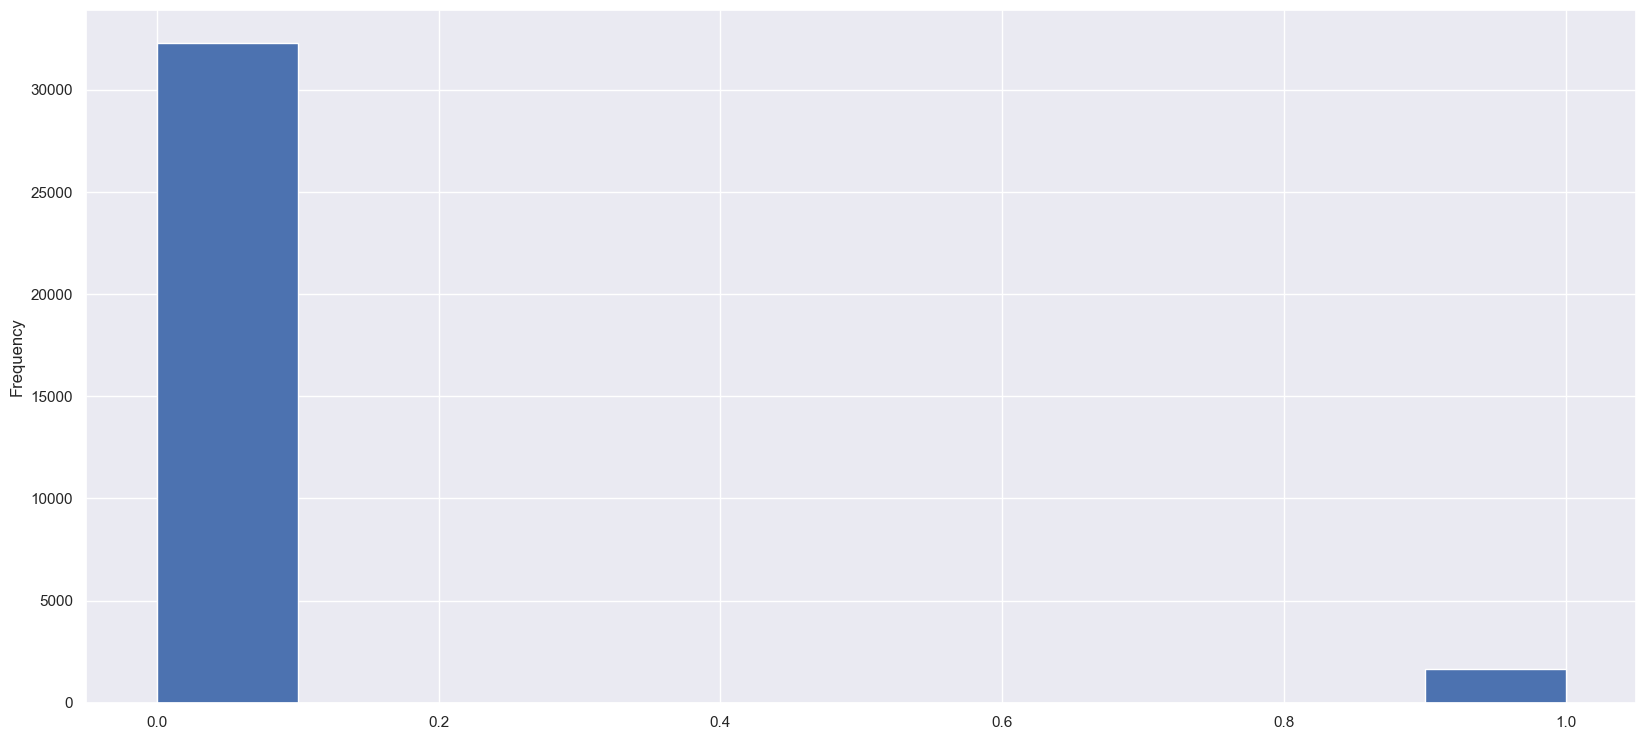

In [69]:
target['target_month'].plot(kind='hist')
plt.show()

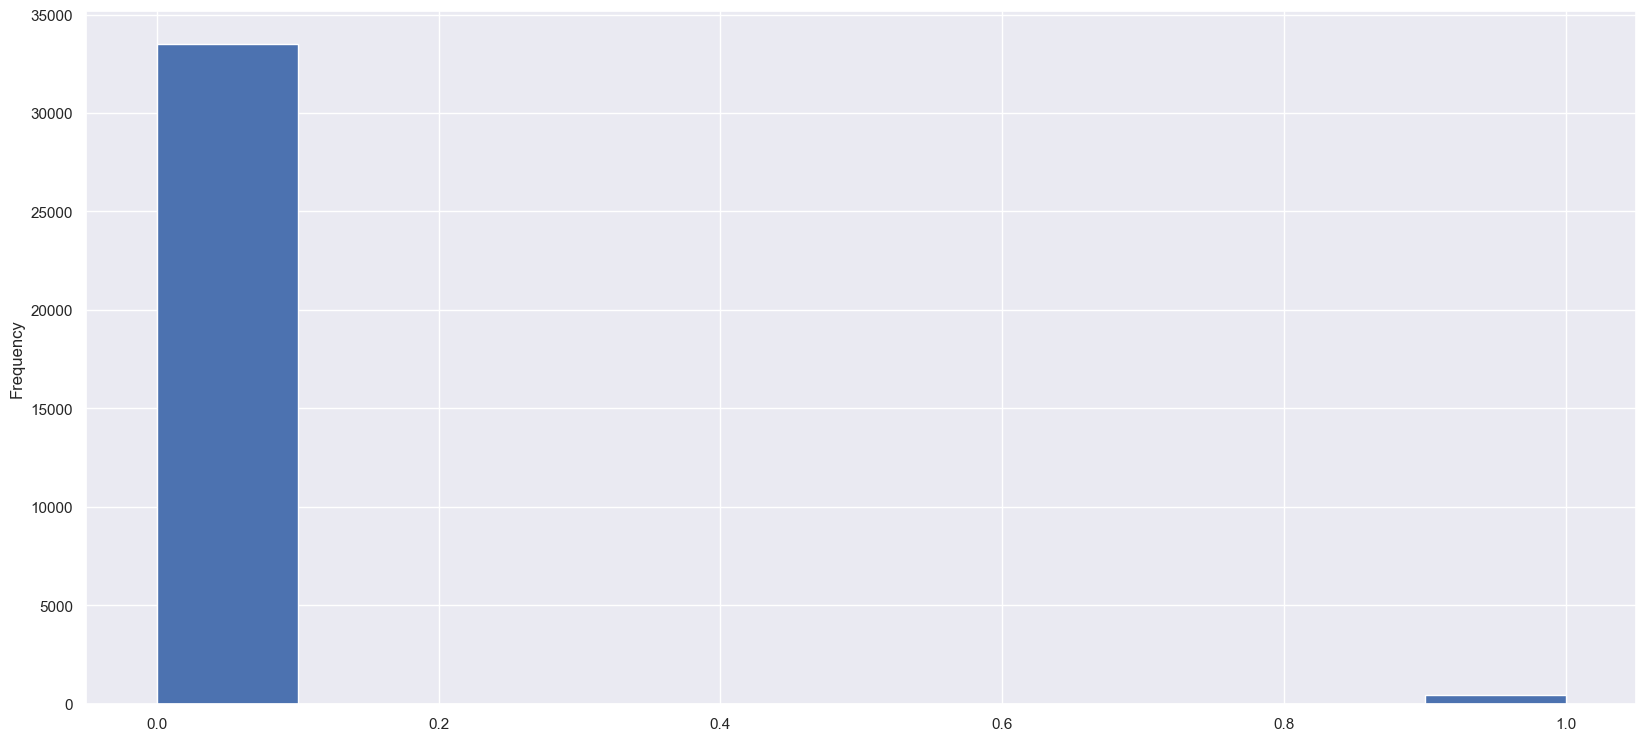

In [70]:
target['target_day'].plot(kind='hist')
plt.show()

# Первичный анализ

# EDA

Посмотреть:
1. Какие параметры из wag_params (тmodel и т.д.) чаще ломаются. Проверить разные типы вагонов
2. Распределения
    1. Кол-во ремонтов на месяц службы
    1. Распределение кол-ва дней до ремонта после ремонта текущего/планового
    1. Распределение при каких значениях в момент среза наступает ремонт в течение месяца

Проверить теорию о влиянии параметров на текущие ремонты:
* Интенсивность эксплуатации, разная норма расхода пробега между ремонтами. Может определятся:
    * География
    * Кто использует вагон
* Перевозимые грузы, посмотреть часто перевозимые грузы по вагонам и их влияние на текущие ремонты
* Норма пробега между плановыми ремонтами
* Календарная норма между плановыми ремонтами

Особое внимание - истечение межремонтного интервала (км пробега) от чего зависит, текущие ремонты снижают межремонтный интервал

## Влияние различных параметров на текущие ремонты

Посчитаем среднемесячное кол-во на ремонт в зависимости от параметров

### Создаём функцию

In [126]:
tr_rem_copy = tr_rem.copy() 

In [127]:
tr_rem_copy['month'] = \
tr_rem_copy['rem_month'].dt.month

In [138]:
tr_rem_copy['month'].unique()

array([ 8,  9, 10, 11, 12,  1], dtype=int64)

In [160]:
tr_rem_wag_mon =\
tr_rem_copy.groupby(['wagnum', 'month'])['kod_vrab'].count()\
.reset_index('month')

In [161]:
wag_param_mon_join =\
tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')

In [162]:
wag_param_mon_join_agg =\
wag_param_mon_join.groupby(['month', 'model'])\
.agg({'kod_vrab': 'sum', 'model': 'count'})

In [139]:
# wag_param_mon_join_agg['w_tr_rem'] = (wag_param_mon_join_agg['kod_vrab'] * wag_param_mon_join_agg['model']).sum() / (wag_param_mon_join_agg['model']).sum()

In [164]:
wag_param_mon_join_agg =\
wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem', 'model': 'count_wag'})

In [165]:
wag_param_mon_join_agg.head()

count_tr_rem  count_wag
month model                              
1     11-1268               17          8
      11-1807              104         50
      11-1807-01           514        267
      11-2135-01           317        172
      11-2163              142         86

In [170]:
wag_param_mon_join_agg['rem_wag_per_m'] = wag_param_mon_join_agg['count_tr_rem'] / wag_param_mon_join_agg['count_wag']

In [172]:
wag_param_mon_join_agg.reset_index(inplace=True)

In [173]:
wag_param_mon_join_agg.head()

,month,model,count_tr_rem,count_wag,rem_wag_per_m
0,1,11-1268,17,8,2.125000
1,1,11-1807,104,50,2.080000
2,1,11-1807-01,514,267,1.925094
3,1,11-2135-01,317,172,1.843023
4,1,11-2163,142,86,1.651163


In [176]:
wag_param_mon_join_agg.groupby('model').mean()['rem_wag_per_m'].sort_values(ascending=False)

model
12-9837       2.416667
12-600-04     2.337418
12-600-02     2.298310
12-600-08     2.234900
12-295        2.149797
12-600-05     2.149665
12-1704-04    2.143623
12-783        2.128316
12-955        2.108333
11-270        2.077381
12-9046       2.068637
12-196-01     2.066667
12-1302       2.066667
12-9790       2.066100
12-9780       2.046413
12-9766       2.046053
12-7023-02    2.039045
12-9788-01    2.032590
12-9085       2.029861
12-4102       2.019333
11-1807       2.017092
12-532-02     2.000000
12-600-07     2.000000
12-753-03     2.000000
11-066-04     2.000000
Р-9494-01     2.000000
11-259        2.000000
12-296-01     1.995802
12-132-03     1.995548
11-7038       1.993400
12-132        1.975041
11-286        1.955645
12-1303-01    1.926767
11-280        1.920707
11-1807-01    1.914535
12-196-02     1.911331
11-276        1.904504
11-2135-01    1.889737
11-1268       1.881944
11-260        1.850000
12-9745       1.833333
11-9962       1.820508
11-264        1.777778
11-28

### Функция

In [192]:
def count_rems_per_month(tr_rem, wag_param, month_to_predict, col, months=False):
    tr_rem_copy = tr_rem.copy()
    
    tr_rem_copy = tr_rem_copy[tr_rem_copy['rem_month'] < month_to_predict]
    
    tr_rem_copy['month'] = \
    tr_rem_copy['rem_month'].dt.month
    if months:
        print('Месяца', tr_rem_copy['month'].unique())
    
    tr_rem_wag_mon =\
    tr_rem_copy.groupby(['wagnum', 'month'])['kod_vrab'].count()\
    .reset_index('month')
    
    wag_param_mon_join =\
    tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')
    
    wag_param_mon_join_agg =\
    wag_param_mon_join.groupby(['month', col])\
    .agg({'kod_vrab': 'sum', col: 'count'})
    
    wag_param_mon_join_agg =\
    wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem', col: 'count_wag'})
    
    wag_param_mon_join_agg['rem_wag_per_m'] = wag_param_mon_join_agg['count_tr_rem'] / wag_param_mon_join_agg['count_wag']
    
    return wag_param_mon_join_agg

In [194]:
count_rems_per_month(tr_rem, wag_param, '2023-01-01', 'model', True)

Месяца [ 8  9 10 11 12]


count_tr_rem  count_wag  rem_wag_per_m
month model                                             
8     11-066-04              2          1       2.000000
      11-1268                3          2       1.500000
      11-1807               70         38       1.842105
      11-1807-01           427        227       1.881057
      11-2135-01           337        183       1.841530
...                        ...        ...            ...
12    12-9780               77         34       2.264706
      12-9788-01           122         66       1.848485
      12-9790               42         22       1.909091
      12-9850-02             1          1       1.000000
      Р-9494-01              2          1       2.000000

[199 rows x 3 columns]

### Проверяем параметры вагона **wag_param**

In [188]:
wag_params = list(wag_param.columns)

In [189]:
wag_params.remove('wagnum')

In [190]:
wag_params

['model',
 'rod_id',
 'gruz',
 'cnsi_gruz_capacity',
 'cnsi_volumek',
 'tara',
 'date_build',
 'srok_sl',
 'zavod_build',
 'date_iskl',
 'cnsi_probeg_dr',
 'cnsi_probeg_kr',
 'kuzov',
 'telega',
 'tormoz',
 'tipvozd',
 'tippogl',
 'norma_km',
 'ownertype']

In [197]:
for param in wag_params:
    df_rem_by_param = count_rems_per_month(tr_rem, wag_param, '2023-01-01', param)
    
    print('Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных')
    rem_by_param_group=\
    df_rem_by_param.groupby(param).mean()['rem_wag_per_m'].sort_values(ascending=False)
    
    print(rem_by_param_group.head(10))

Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
model
12-9837       2.416667
12-600-04     2.321569
12-600-02     2.291305
12-600-08     2.215214
12-295        2.208328
12-1704-04    2.175378
12-600-05     2.163271
12-955        2.130000
12-9085       2.124722
12-783        2.118844
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
rod_id
1    2.003911
0    1.906747
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
gruz
682    2.321569
706    2.291305
696    2.215214
693    2.163271
700    2.043672
688    2.042857
710    2.042292
703    2.031123
719    2.000000
695    1.969871
Name: rem_wag_per_m, dtype: float64
Средне-месячное кол-во ТР одного вагона для значений параметра. Топ-10 самых токсичных
cnsi_gruz_capacity
682    2.321569
706    2.291305
696    2.215214
693    2.163271
700    2.043672
688    2.

## Может ли вагон отправится в плановый ремонт в течение 10 дней, не отправляясь в течение месяца

Проверим может ли в target быть `target_day = 1`, когда `target_month = 0`

In [131]:
# Кол-во таргетов, где target_day == 1 and target_month == 0
target.query('target_day == 1 and target_month == 0')['wagnum'].count()

0

**Вывод:** нет, не может. Значит может для предикта target_day брать предикты target_month с истинной меткой

# Предобработка данных

# Feature engineering

## Средне-месячное кол-во ТР для вагона и всех его параметров

In [265]:
def count_rems_per_month_one_wag(tr_rem, wag_param, month_to_predict, months=False):
    tr_rem_copy = tr_rem.copy()
    
    tr_rem_copy = tr_rem_copy[tr_rem_copy['rem_month'] < month_to_predict]
    
    tr_rem_copy['month'] = \
    tr_rem_copy['rem_month'].dt.month
    if months:
        print('\nМесяца count_rems_per_month_one_wag', tr_rem_copy['month'].unique(), '\n')
    
    tr_rem_wag_mon =\
    tr_rem_copy.groupby(['wagnum', 'month'])[['kod_vrab']].count()
    
    wag_param_mon_join =\
    tr_rem_wag_mon.join(wag_param.set_index('wagnum'), how='inner')
    
    wag_param_mon_join_agg =\
    wag_param_mon_join.groupby(['wagnum', 'month'])\
    .agg({'kod_vrab': 'sum'})
    
    wag_param_mon_join_agg =\
    wag_param_mon_join_agg.rename(columns={'kod_vrab': 'count_tr_rem_per_m'})
    
    
    return wag_param_mon_join_agg.reset_index()

In [279]:
wag_rem_months = count_rems_per_month_one_wag(tr_rem, wag_param, '2023-12-01', True)


Месяца count_rems_per_month_one_wag [ 8  9 10 11 12  1] 



In [227]:
wag_rem_months_group = wag_rem_months.groupby('wagnum').mean()[['count_tr_rem_per_m']].reset_index()

In [228]:
wag_rem_months_group.head()

,wagnum,count_tr_rem_per_m
0,0,1.0
1,2,2.0
2,3,2.0
3,6,3.0
4,8,2.0


In [231]:
wag_rem_months_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15845 entries, 0 to 15844
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wagnum              15845 non-null  Int64  
 1   count_tr_rem_per_m  15845 non-null  float64
dtypes: Int64(1), float64(1)
memory usage: 263.2 KB


In [233]:
wag_param_test_merge =\
wag_param.merge(wag_rem_months_group, on='wagnum', how='left')

In [234]:
wag_param_test_merge

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,...,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,count_tr_rem_per_m
0,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,...,160,160,2,9,3,6,11,110000,0,NaN
1,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,...,110,160,2,9,2,1,12,0,0,2.0
2,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,...,110,160,2,9,2,1,1,160000,1,NaN
3,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,...,250,500,2,11,2,7,12,250000,1,1.0
4,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,...,110,160,2,9,2,1,11,160000,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33972,18766,11-280,0,680,680,138.0,259,2013-01-07,2046-03-20,1,...,110,160,2,9,2,7,12,160000,0,2.0
33973,18769,11-280,0,680,680,138.0,259,2013-01-18,2046-02-14,1,...,110,160,2,9,2,7,12,160000,0,NaN
33974,18899,11-280,0,680,680,138.0,260,2013-07-24,2044-03-03,1,...,110,160,2,9,2,7,11,160000,0,NaN
33975,18912,11-280,0,680,680,138.0,259,2015-02-28,2044-08-04,1,...,110,160,2,9,2,7,11,160000,0,NaN


In [240]:
for param in wag_params:
    df_rem_by_param = count_rems_per_month(tr_rem, wag_param, '2023-01-01', param)
    
    rem_by_param_group=\
    df_rem_by_param.groupby(param).mean()[['rem_wag_per_m']]
    
    rem_by_param_group=\
    rem_by_param_group.rename(columns={'rem_wag_per_m': f'{param}_rem_wag_per_m'})
    
    wag_param_test_merge =\
    wag_param_test_merge.merge(rem_by_param_group, on=param)

In [241]:
wag_param_test_merge

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,...,date_iskl_rem_wag_per_m,cnsi_probeg_dr_rem_wag_per_m,cnsi_probeg_kr_rem_wag_per_m,kuzov_rem_wag_per_m,telega_rem_wag_per_m,tormoz_rem_wag_per_m,tipvozd_rem_wag_per_m,tippogl_rem_wag_per_m,norma_km_rem_wag_per_m,ownertype_rem_wag_per_m
0,6318,11-276,0,680,680,122.0,260,1993-01-10,2024-12-26,1,...,1.666667,1.969925,1.979759,1.978347,1.979041,1.992717,1.977924,1.938522,1.980489,1.977069
1,6327,11-276,0,680,680,122.0,260,1991-12-18,2022-06-11,1,...,1.666667,1.969925,1.979759,1.978347,1.979041,1.992717,1.977924,1.938522,1.980489,1.977069
2,6,11-270,0,688,688,122.0,237,1996-08-21,2026-09-18,1,...,1.850000,1.969925,1.979759,1.978347,1.979041,1.992717,1.977924,1.938522,1.980489,1.977069
3,7264,11-286,0,670,670,138.0,270,1993-06-01,2028-09-21,1,...,1.850000,1.969925,1.979759,1.978347,1.979041,1.992717,1.977924,1.938522,1.980489,1.977069
4,28577,12-132,1,695,695,88.0,245,2002-11-11,2025-09-06,0,...,2.666667,1.969925,1.979759,1.978347,1.979041,1.992717,1.977924,1.981439,1.980489,1.977069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,28488,12-132,1,695,695,88.0,245,2000-10-10,2023-07-31,0,...,2.000000,1.969925,1.979759,1.978347,1.979041,1.967759,1.977924,1.992039,2.035087,1.977069
59,28586,12-132,1,695,695,88.0,244,2001-04-12,2025-07-28,0,...,2.666667,1.969925,1.979759,1.978347,1.979041,1.992717,2.040954,1.992039,2.035087,1.977069
60,28524,12-132,1,695,695,88.0,245,2001-05-24,2026-02-04,0,...,2.233333,1.969925,1.979759,1.978347,1.979041,1.967759,2.040954,1.992039,2.035087,1.977069
61,28573,12-132,1,695,695,88.0,244,2002-10-16,2023-07-14,0,...,1.833333,1.969925,1.979759,1.978347,1.979041,1.967759,2.040954,1.992039,2.035087,1.977069


## Собираем всё в функцию

In [292]:
def all_rems_for_wagon(tr_rem, wag_param, month_to_predict, m=True):
    wag_params = list(wag_param.columns)
    wag_params.remove('wagnum')
    wag_params.remove('date_iskl')
    
    wag_rem_months = count_rems_per_month_one_wag(tr_rem, wag_param, month_to_predict, m)
    
    wag_rem_months_group = wag_rem_months.groupby('wagnum').mean()[['count_tr_rem_per_m']].reset_index()
    
    wag_param = wag_param.copy()
    
    wag_param_test_merge =\
    wag_param.merge(wag_rem_months_group, on='wagnum', how='left')
    
    for param in wag_params:
        df_rem_by_param = count_rems_per_month(tr_rem, wag_param, month_to_predict, param, m)

        rem_by_param_group=\
        df_rem_by_param.groupby(param).mean()[['rem_wag_per_m']]

        rem_by_param_group=\
        rem_by_param_group.rename(columns={'rem_wag_per_m': f'{param}_rem_wag_per_m'})

        wag_param_test_merge =\
        wag_param_test_merge.merge(rem_by_param_group, on=param, how='left')
        
    return wag_param_test_merge

In [283]:
all_rems_for_wagon(tr_rem, wag_param, '2022-12-01')


Месяца count_rems_per_month_one_wag [ 8  9 10 11] 

Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]


,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,...,date_iskl_rem_wag_per_m,cnsi_probeg_dr_rem_wag_per_m,cnsi_probeg_kr_rem_wag_per_m,kuzov_rem_wag_per_m,telega_rem_wag_per_m,tormoz_rem_wag_per_m,tipvozd_rem_wag_per_m,tippogl_rem_wag_per_m,norma_km_rem_wag_per_m,ownertype_rem_wag_per_m
0,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,...,NaN,2.114423,1.976443,1.974733,1.974436,1.987832,2.003456,1.982032,1.998404,1.975263
1,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,...,2.0,1.966344,1.976443,1.974733,1.974436,1.966333,1.966179,1.958749,1.729347,1.975263
2,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.966179,1.909314,1.978170,1.903641
3,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,...,NaN,NaN,1.890870,1.974733,1.890870,1.966333,1.967485,1.958749,NaN,1.903641
4,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.966179,1.982032,1.978170,1.903641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33972,18766,11-280,0,680,680,138.0,259,2013-01-07,2046-03-20,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.967485,1.958749,1.978170,1.975263
33973,18769,11-280,0,680,680,138.0,259,2013-01-18,2046-02-14,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.967485,1.958749,1.978170,1.975263
33974,18899,11-280,0,680,680,138.0,260,2013-07-24,2044-03-03,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.967485,1.982032,1.978170,1.975263
33975,18912,11-280,0,680,680,138.0,259,2015-02-28,2044-08-04,1,...,NaN,1.966344,1.976443,1.974733,1.974436,1.966333,1.967485,1.982032,1.978170,1.975263


# Функция для создания данных

In [366]:
def make_wp(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict]
    print('target', target['month'].unique())
    target = target[['wagnum','target_month','target_day']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == month_to_predict)| (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nwag_prob', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_[['wagnum','mean_run']])
    
    print('\nwag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param = all_rems_for_wagon(tr_rem, wag_param, month_to_predict, True)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem', pr_rem['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem.loc['was_repair_in_prev_month'] = 1
    pr_rem = pr_rem[['wagnum','was_repair_in_prev_month']]
    pr_rem = pr_rem.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\ndislok', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']].merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, how = 'left')\
    .merge(pr_rem, how = 'left')\
    .merge(tr_rem, how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [358]:
def make_features_wp(wp, target, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи и таргет
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = month_to_predict
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = wp['srok_sl']- wp['current_date']
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = wp['date_pl_rem']- wp['current_date']
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run']* 30
    
    # print('Заполняме пропуски')
    # numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # # Заменим отсутствующие значения на нули
    # wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
    
    # Таргет
    y = target.set_index('wagnum').sort_index()
    
    # Если month == True, то оставляем таргет только для месяца
    if month:
        y = y['target_month']
        
    return X, y

# Тренировочный датасет

In [367]:
# %%time
wp_train, target_train = make_wp(wag_param_clear, wag_prob_clear, pr_rem_clear, tr_rem_clear, dislok_clear, target_clear, '2022-12-01', 11)

target ['2022-12-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11] 

Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]
Месяца [ 8  9 10 11]

pr_rem 11
tr_rem 11

dislok ['2022-12-01T00:00:00.000000000']

Делаем фичи

Заполняме пропуски


In [368]:
wp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33977 non-null  Int64         
 1   model                             33977 non-null  string        
 2   rod_id                            33977 non-null  Int64         
 3   gruz                              33977 non-null  Int64         
 4   cnsi_gruz_capacity                33977 non-null  Int64         
 5   cnsi_volumek                      33977 non-null  Float64       
 6   tara                              33977 non-null  Int64         
 7   date_build                        33977 non-null  datetime64[ns]
 8   srok_sl                           33977 non-null  datetime64[ns]
 9   zavod_build                       33977 non-null  Int64         
 10  cnsi_probeg_dr                    33977 non-nu

In [369]:
wp_train.columns

Index(['wagnum', 'model', 'rod_id', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build',
       'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz',
       'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'count_tr_rem_per_m',
       'model_rem_wag_per_m', 'rod_id_rem_wag_per_m', 'gruz_rem_wag_per_m',
       'cnsi_gruz_capacity_rem_wag_per_m', 'cnsi_volumek_rem_wag_per_m',
       'tara_rem_wag_per_m', 'date_build_rem_wag_per_m',
       'srok_sl_rem_wag_per_m', 'zavod_build_rem_wag_per_m',
       'cnsi_probeg_dr_rem_wag_per_m', 'cnsi_probeg_kr_rem_wag_per_m',
       'kuzov_rem_wag_per_m', 'telega_rem_wag_per_m', 'tormoz_rem_wag_per_m',
       'tipvozd_rem_wag_per_m', 'tippogl_rem_wag_per_m',
       'norma_km_rem_wag_per_m', 'ownertype_rem_wag_per_m', 'ost_prob',
       'mean_run', 'was_repair_in_prev_month', 'kod_vrab', 'date_pl_rem'],
      dtype='object')

In [315]:
# target_train.value_counts()

In [370]:
%%time
X_train, y_train = make_features_wp(wp_train, target_train)

Считаем среднедневный пробег
Сортируем номега вагонов
CPU times: total: 2.44 s
Wall time: 2.52 s


In [371]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             33977 non-null  string         
 1   rod_id                            33977 non-null  Int64          
 2   gruz                              33977 non-null  Int64          
 3   cnsi_gruz_capacity                33977 non-null  Int64          
 4   cnsi_volumek                      33977 non-null  Float64        
 5   tara                              33977 non-null  Int64          
 6   date_build                        33977 non-null  datetime64[ns] 
 7   srok_sl                           33977 non-null  datetime64[ns] 
 8   zavod_build                       33977 non-null  Int64          
 9   cnsi_probeg_dr                    33977 non-null  Int64          
 10  cnsi_probeg_kr                    33977

In [372]:
X_train.head()

,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,cnsi_probeg_dr,...,ost_prob,mean_run,was_repair_in_prev_month,kod_vrab,date_pl_rem,day_run,current_date,date_diff_srk_sl,date_diff_pl_rem,prob_end_month
wagnum,,,,,,,,,,,,,,,,,,,,,
0,11-276,0,680,680,122.0,244,1993-06-17,2025-12-03,1,110,...,63190,157.565574,0.0,1.0,2023-05-06,142.521858,2023-12-01,733 days,-209 days,58914.344262
1,11-066-04,0,680,680,120.0,220,1994-07-09,2026-03-07,1,110,...,97917,284.778689,1.0,0.0,2024-07-01,184.926230,2023-12-01,827 days,213 days,92369.213115
2,Р-9494-01,0,680,680,122.0,252,1994-10-30,2026-11-15,1,110,...,59169,83.409836,0.0,0.0,2024-08-19,117.803279,2023-12-01,1080 days,262 days,55634.901639
3,11-066-04,0,680,680,120.0,220,1993-10-04,2025-10-03,1,110,...,67032,136.02459,0.0,0.0,2024-04-01,135.341530,2023-12-01,672 days,122 days,62971.754098
4,11-217,0,680,680,120.0,235,1994-06-03,2028-08-01,23,110,...,108149,63.278689,0.0,0.0,2024-11-28,111.092896,2023-12-01,1705 days,363 days,104816.213115


In [373]:
y_train.head()

wagnum
0    0
1    0
2    0
3    0
4    0
Name: target_month, dtype: Int64

In [374]:
y_train.value_counts()

0    32393
1     1584
Name: target_month, dtype: Int64

# Тестовый датасет

In [408]:
# %%time
wp_test, target_test = make_wp(wag_param_clear, wag_prob_clear, pr_rem_clear, tr_rem_clear, dislok_clear, target_clear, '2023-01-01', 12)

target ['2023-01-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2023-01-01T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11 12] 

Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]
Месяца [ 8  9 10 11 12]

pr_rem 12
tr_rem 12

dislok ['2022-12-07T00:00:00.000000000' '2022-12-31T00:00:00.000000000'
 '2022-12-12T00:00:00.000000000' '2022-12-22T00:00:00.000000000'
 '2023-01-01T00:00:00.000000000']

Делаем фичи

Заполняме пропуски


In [409]:
wp_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33973 entries, 0 to 33972
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33973 non-null  Int64         
 1   model                             33973 non-null  string        
 2   rod_id                            33973 non-null  Int64         
 3   gruz                              33973 non-null  Int64         
 4   cnsi_gruz_capacity                33973 non-null  Int64         
 5   cnsi_volumek                      33973 non-null  Float64       
 6   tara                              33973 non-null  Int64         
 7   date_build                        33973 non-null  datetime64[ns]
 8   srok_sl                           33973 non-null  datetime64[ns]
 9   zavod_build                       33973 non-null  Int64         
 10  cnsi_probeg_dr                    33973 non-nu

In [315]:
# target_train.value_counts()

In [410]:
X_test, y_test = make_features_wp(wp_test, target_test)

Считаем среднедневный пробег
Сортируем номега вагонов


In [411]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33973 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             33973 non-null  string         
 1   rod_id                            33973 non-null  Int64          
 2   gruz                              33973 non-null  Int64          
 3   cnsi_gruz_capacity                33973 non-null  Int64          
 4   cnsi_volumek                      33973 non-null  Float64        
 5   tara                              33973 non-null  Int64          
 6   date_build                        33973 non-null  datetime64[ns] 
 7   srok_sl                           33973 non-null  datetime64[ns] 
 8   zavod_build                       33973 non-null  Int64          
 9   cnsi_probeg_dr                    33973 non-null  Int64          
 10  cnsi_probeg_kr                    33973

In [412]:
y_test.value_counts()

0    32297
1     1676
Name: target_month, dtype: Int64

# Simple model. Месяц

## Обучаем

In [375]:
cols_cat_n = X_train.select_dtypes(include=['string', 'object'])

In [376]:
cols_cat_n_list = list(cols_cat_n.columns)

In [377]:
cols_cat_n_list

['model', 'tipvozd']

In [387]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [533]:
scale_pos_weight

1.0

In [388]:
clf_new = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', scale_pos_weight=scale_pos_weight, cat_features=cols_cat_n_list)

In [389]:
clf_new.fit(X_train, y_train)

0:	learn: 0.6765753	total: 43.7ms	remaining: 4.33s
1:	learn: 0.6602370	total: 80.2ms	remaining: 3.93s
2:	learn: 0.6454855	total: 119ms	remaining: 3.85s
3:	learn: 0.6311278	total: 156ms	remaining: 3.75s
4:	learn: 0.6161042	total: 196ms	remaining: 3.72s
5:	learn: 0.6020848	total: 239ms	remaining: 3.74s
6:	learn: 0.5885816	total: 283ms	remaining: 3.76s
7:	learn: 0.5761491	total: 323ms	remaining: 3.72s
8:	learn: 0.5636375	total: 362ms	remaining: 3.66s
9:	learn: 0.5519178	total: 407ms	remaining: 3.66s
10:	learn: 0.5395713	total: 451ms	remaining: 3.65s
11:	learn: 0.5291729	total: 499ms	remaining: 3.66s
12:	learn: 0.5184426	total: 631ms	remaining: 4.22s
13:	learn: 0.5080257	total: 725ms	remaining: 4.45s
14:	learn: 0.4978708	total: 772ms	remaining: 4.38s
15:	learn: 0.4871744	total: 809ms	remaining: 4.25s
16:	learn: 0.4783353	total: 846ms	remaining: 4.13s
17:	learn: 0.4693738	total: 887ms	remaining: 4.04s
18:	learn: 0.4605391	total: 934ms	remaining: 3.98s
19:	learn: 0.4522732	total: 982ms	remai

In [390]:
cross_val_score(clf_new, X_train, y_train, scoring = 'f1', cv=5).mean()

0:	learn: 0.6797409	total: 33.9ms	remaining: 3.36s
1:	learn: 0.6650814	total: 78.5ms	remaining: 3.85s
2:	learn: 0.6483381	total: 120ms	remaining: 3.87s
3:	learn: 0.6342804	total: 158ms	remaining: 3.8s
4:	learn: 0.6245771	total: 189ms	remaining: 3.58s
5:	learn: 0.6117835	total: 230ms	remaining: 3.6s
6:	learn: 0.6019788	total: 287ms	remaining: 3.81s
7:	learn: 0.5899936	total: 327ms	remaining: 3.76s
8:	learn: 0.5808335	total: 367ms	remaining: 3.71s
9:	learn: 0.5691430	total: 407ms	remaining: 3.66s
10:	learn: 0.5590258	total: 443ms	remaining: 3.58s
11:	learn: 0.5485821	total: 479ms	remaining: 3.51s
12:	learn: 0.5372282	total: 517ms	remaining: 3.46s
13:	learn: 0.5282623	total: 551ms	remaining: 3.38s
14:	learn: 0.5195298	total: 588ms	remaining: 3.33s
15:	learn: 0.5086113	total: 621ms	remaining: 3.26s
16:	learn: 0.4973060	total: 655ms	remaining: 3.2s
17:	learn: 0.4908041	total: 690ms	remaining: 3.14s
18:	learn: 0.4837036	total: 724ms	remaining: 3.08s
19:	learn: 0.4737621	total: 761ms	remainin

0.45058156326088916

``f1 = 0.450``

In [401]:
y_pred_tr = clf_new.predict(X_train)

In [402]:
y_pred_tr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Важность признаков

In [392]:
feature_importance = clf_new.get_feature_importance(data=None, type='FeatureImportance')

In [394]:
# Сортируем важность признаков
sorted_idx = feature_importance.argsort()
sorted_feature_importances = feature_importance[sorted_idx]
sorted_feature_names = X_train.columns[sorted_idx]

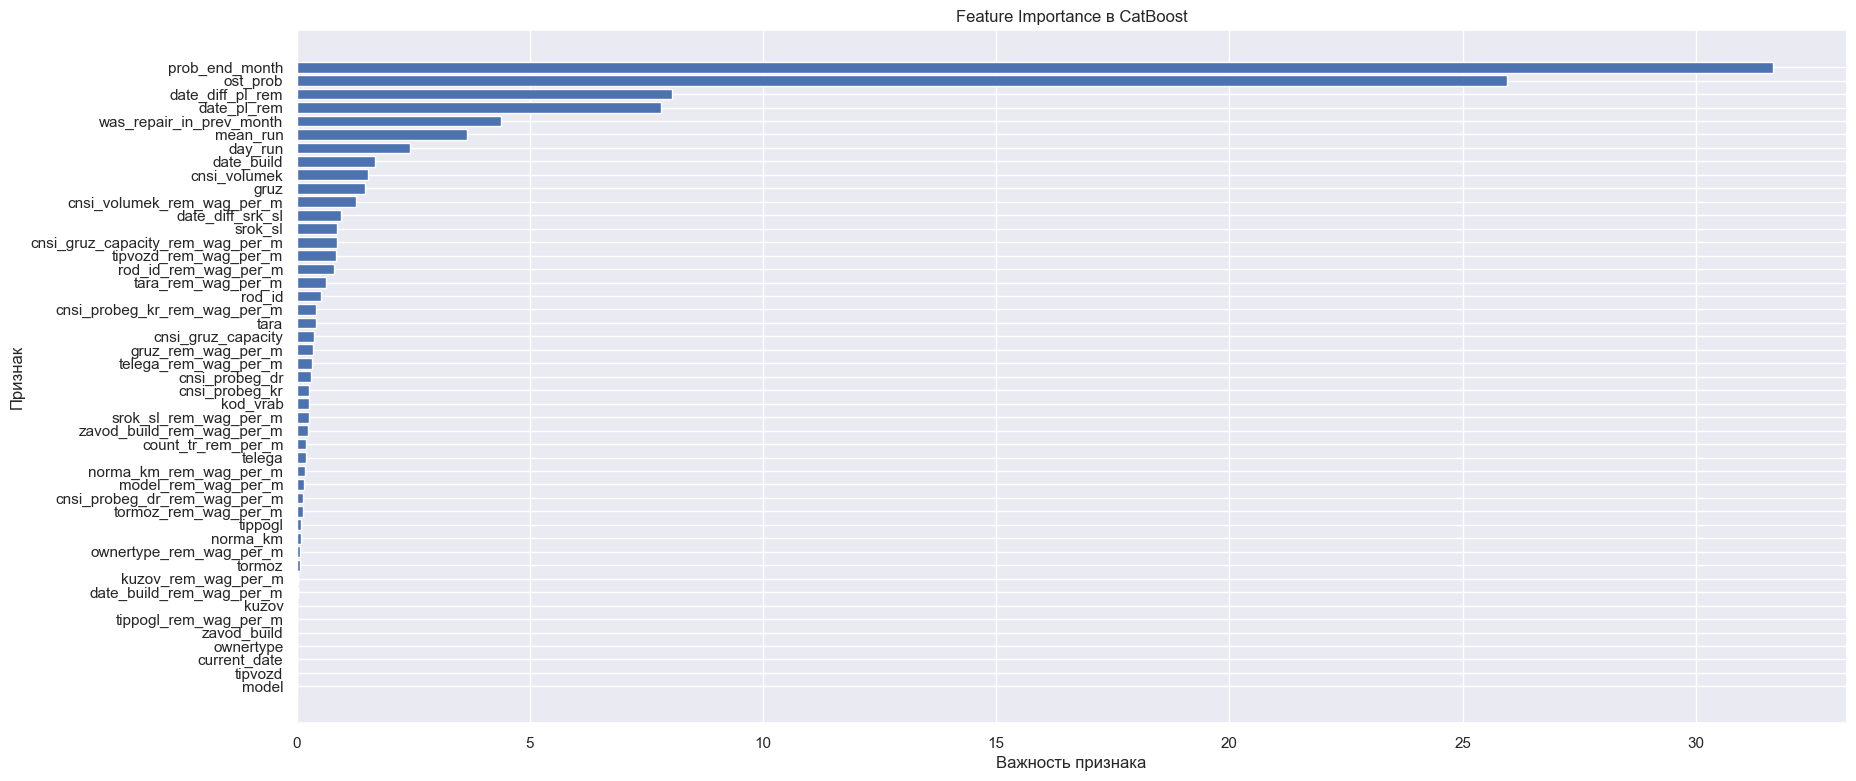

In [399]:
# Строим график важности признаков
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Feature Importance в CatBoost')
plt.show()

## CM

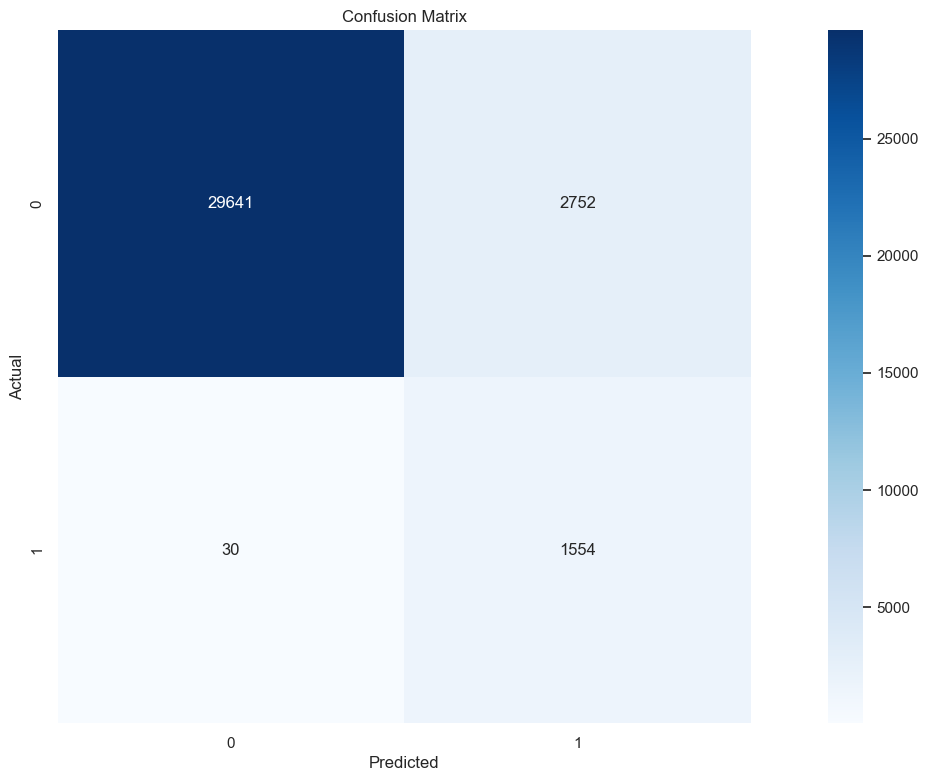

In [404]:
# Создание матрицы ошибок
confusion = confusion_matrix(y_train, y_pred_tr)

# Визуализация матрицы ошибок с использованием библиотеки Seaborn
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Threshold

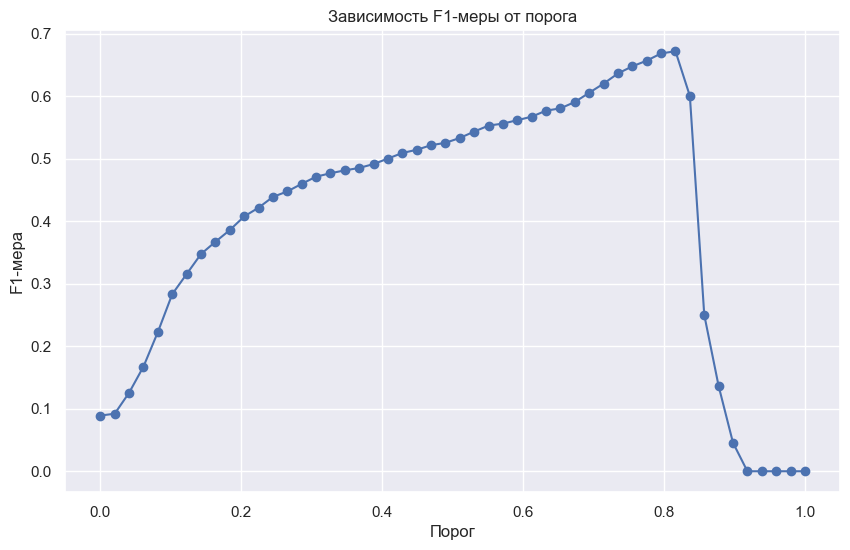

Лучший порог: 0.8163265306122448


In [405]:
y_pred1 = clf_new.predict_proba(X_train)[:, 1]
y_true = y_train

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [414]:
y_pred_tr1 = clf_new.predict_proba(X_train)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train)
f1

0.6721529068224049

## Тестим

In [415]:
cross_val_score(clf_new, X_test, y_test, scoring = 'f1', cv=5).mean()

0:	learn: 0.6779638	total: 40.6ms	remaining: 4.02s
1:	learn: 0.6653546	total: 90.1ms	remaining: 4.41s
2:	learn: 0.6537649	total: 126ms	remaining: 4.06s
3:	learn: 0.6389737	total: 163ms	remaining: 3.9s
4:	learn: 0.6288453	total: 200ms	remaining: 3.79s
5:	learn: 0.6178637	total: 237ms	remaining: 3.71s
6:	learn: 0.6079949	total: 270ms	remaining: 3.59s
7:	learn: 0.5970906	total: 314ms	remaining: 3.61s
8:	learn: 0.5848006	total: 349ms	remaining: 3.53s
9:	learn: 0.5712505	total: 383ms	remaining: 3.45s
10:	learn: 0.5621803	total: 421ms	remaining: 3.4s
11:	learn: 0.5538234	total: 454ms	remaining: 3.33s
12:	learn: 0.5420080	total: 496ms	remaining: 3.32s
13:	learn: 0.5334949	total: 529ms	remaining: 3.25s
14:	learn: 0.5255836	total: 562ms	remaining: 3.18s
15:	learn: 0.5167371	total: 593ms	remaining: 3.11s
16:	learn: 0.5095918	total: 626ms	remaining: 3.06s
17:	learn: 0.5026550	total: 655ms	remaining: 2.98s
18:	learn: 0.4949296	total: 688ms	remaining: 2.93s
19:	learn: 0.4867380	total: 726ms	remaini

0.4408767096963221

``f1 = 0.44``

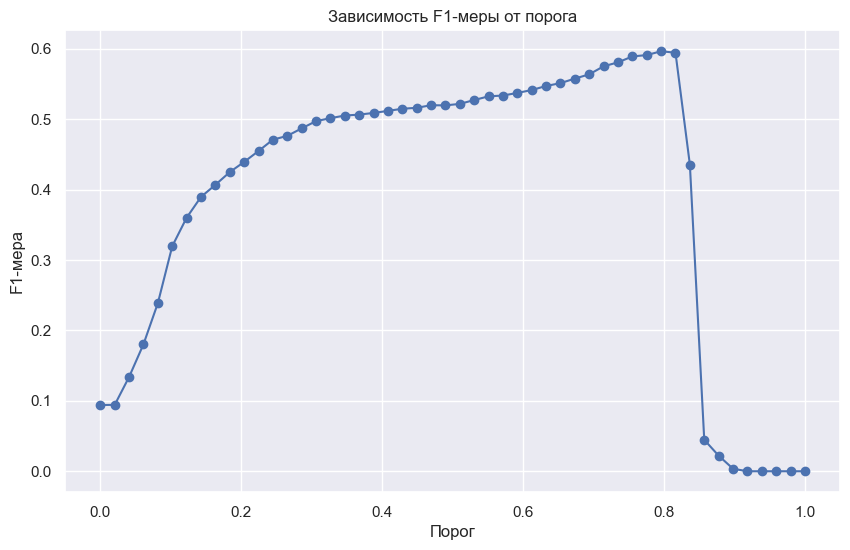

Лучший порог: 0.7959183673469387


In [416]:
y_pred1 = clf_new.predict_proba(X_test)[:, 1]
y_true = y_test

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [418]:
y_pred_tr1 = clf_new.predict_proba(X_test)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_test)
f1

0.5964912280701755

# Модель с фильтром. Месяц

## Обучение

In [536]:
X_train_filt = X_train.query('was_repair_in_prev_month != 1')

In [537]:
y_train_filt = y_train[X_train_filt.index]

In [538]:
X_train_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32182 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             32182 non-null  string         
 1   rod_id                            32182 non-null  Int64          
 2   gruz                              32182 non-null  Int64          
 3   cnsi_gruz_capacity                32182 non-null  Int64          
 4   cnsi_volumek                      32182 non-null  Float64        
 5   tara                              32182 non-null  Int64          
 6   date_build                        32182 non-null  datetime64[ns] 
 7   srok_sl                           32182 non-null  datetime64[ns] 
 8   zavod_build                       32182 non-null  Int64          
 9   cnsi_probeg_dr                    32182 non-null  Int64          
 10  cnsi_probeg_kr                    32182

In [539]:
y_train_filt.info()

<class 'pandas.core.series.Series'>
Index: 32182 entries, 0 to 33976
Series name: target_month
Non-Null Count  Dtype
--------------  -----
32182 non-null  Int64
dtypes: Int64(1)
memory usage: 565.7 KB


In [540]:
scale_pos_weight = len(y_train_filt[y_train_filt == 0]) / len(y_train_filt[y_train_filt == 1])

In [541]:
scale_pos_weight

19.31691919191919

In [544]:
clf_new_filt = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, loss_function='Logloss', auto_class_weights='SqrtBalanced', cat_features=cols_cat_n_list)

In [545]:
clf_new_filt.fit(X_train_filt, y_train_filt)

0:	learn: 0.6699934	total: 39.2ms	remaining: 3.88s
1:	learn: 0.6487987	total: 76ms	remaining: 3.72s
2:	learn: 0.6275694	total: 112ms	remaining: 3.64s
3:	learn: 0.6090821	total: 150ms	remaining: 3.59s
4:	learn: 0.5893372	total: 187ms	remaining: 3.55s
5:	learn: 0.5717843	total: 225ms	remaining: 3.53s
6:	learn: 0.5548260	total: 270ms	remaining: 3.58s
7:	learn: 0.5368024	total: 311ms	remaining: 3.58s
8:	learn: 0.5209603	total: 350ms	remaining: 3.54s
9:	learn: 0.5087378	total: 386ms	remaining: 3.47s
10:	learn: 0.4931463	total: 421ms	remaining: 3.41s
11:	learn: 0.4793839	total: 456ms	remaining: 3.35s
12:	learn: 0.4666549	total: 498ms	remaining: 3.33s
13:	learn: 0.4538373	total: 541ms	remaining: 3.32s
14:	learn: 0.4415096	total: 584ms	remaining: 3.31s
15:	learn: 0.4307205	total: 634ms	remaining: 3.33s
16:	learn: 0.4186972	total: 673ms	remaining: 3.28s
17:	learn: 0.4068786	total: 712ms	remaining: 3.25s
18:	learn: 0.3964706	total: 772ms	remaining: 3.29s
19:	learn: 0.3869410	total: 826ms	remaini

In [546]:
cross_val_score(clf_new_filt, X_train_filt, y_train_filt, scoring = 'f1', cv=5).mean()

0:	learn: 0.6773778	total: 45.3ms	remaining: 4.48s
1:	learn: 0.6570812	total: 85.3ms	remaining: 4.18s
2:	learn: 0.6415108	total: 119ms	remaining: 3.86s
3:	learn: 0.6287849	total: 149ms	remaining: 3.56s
4:	learn: 0.6057026	total: 184ms	remaining: 3.49s
5:	learn: 0.5937798	total: 216ms	remaining: 3.39s
6:	learn: 0.5820383	total: 249ms	remaining: 3.31s
7:	learn: 0.5706777	total: 286ms	remaining: 3.29s
8:	learn: 0.5549217	total: 321ms	remaining: 3.25s
9:	learn: 0.5421246	total: 355ms	remaining: 3.2s
10:	learn: 0.5290178	total: 388ms	remaining: 3.14s
11:	learn: 0.5174540	total: 416ms	remaining: 3.05s
12:	learn: 0.5075789	total: 450ms	remaining: 3.01s
13:	learn: 0.4958118	total: 482ms	remaining: 2.96s
14:	learn: 0.4847295	total: 527ms	remaining: 2.98s
15:	learn: 0.4762471	total: 563ms	remaining: 2.96s
16:	learn: 0.4674335	total: 602ms	remaining: 2.94s
17:	learn: 0.4566279	total: 639ms	remaining: 2.91s
18:	learn: 0.4462388	total: 677ms	remaining: 2.88s
19:	learn: 0.4352753	total: 719ms	remain

0.5999639320156268

``f1 = 0.59``

## TH

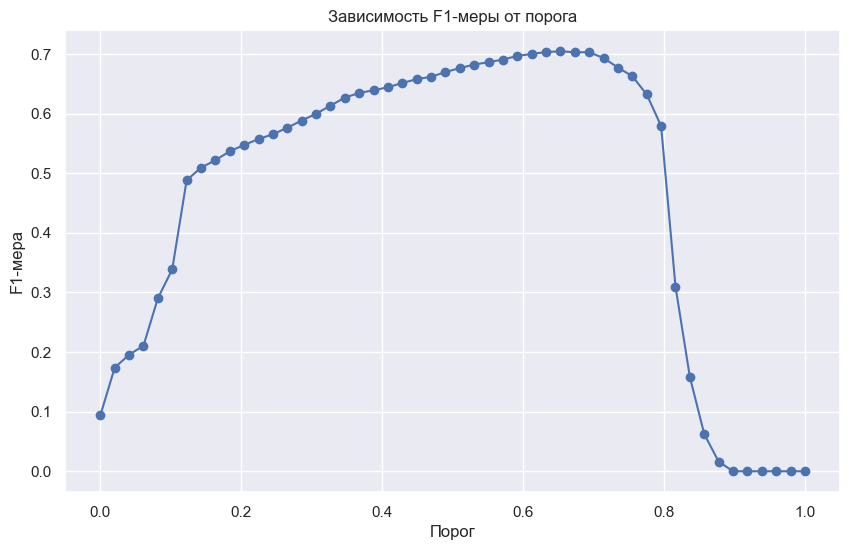

Лучший порог: 0.6530612244897959


In [728]:
y_pred1 = clf_new_filt.predict_proba(X_train_filt)[:, 1]
y_true = y_train_filt

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold_m = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold_m}")

In [768]:
y_pred_tr1 = clf_new_filt.predict_proba(X_train_filt)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train_filt)
f1

0.7046601365390324

In [769]:
sum(y_pred_binary_tr1)

1785

In [549]:
df_pred_binary =\
pd.DataFrame(y_pred_binary_tr1, columns=['pred'], index=y_train_filt.index)

In [550]:
df_pred_binary.head()

,pred
wagnum,
0,0
2,0
3,0
4,0
5,0


In [766]:
df_pred_binary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  33707 non-null  int32
dtypes: int32(1)
memory usage: 1.4 MB


## Важность признаков

In [781]:
feature_importance = clf_new_filt.get_feature_importance(data=None, type='FeatureImportance')

In [782]:
# Сортируем важность признаков
sorted_idx = feature_importance.argsort()
sorted_feature_importances = feature_importance[sorted_idx]
sorted_feature_names = X_train.columns[sorted_idx]

In [790]:
feature_importance = clf_new_filt.get_feature_importance(data=None, type='FeatureImportance')

# Создание списка фичей и их важностей
feature_names = clf_new_filt.feature_names_
feature_importance_list = list(zip(feature_names, feature_importance))

# Сортировка по важности в убывающем порядке
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

cool_feat = []
for feature, importance in feature_importance_list:
    if importance > 0.1:
        cool_feat.append(feature)

In [791]:
cool_feat

['prob_end_month',
 'ost_prob',
 'date_diff_pl_rem',
 'date_pl_rem',
 'mean_run',
 'srok_sl',
 'day_run',
 'cnsi_volumek',
 'rod_id',
 'date_diff_srk_sl',
 'cnsi_gruz_capacity_rem_wag_per_m',
 'gruz',
 'cnsi_volumek_rem_wag_per_m',
 'date_build',
 'tippogl',
 'tara',
 'gruz_rem_wag_per_m',
 'cnsi_gruz_capacity',
 'tipvozd_rem_wag_per_m',
 'model_rem_wag_per_m',
 'norma_km',
 'norma_km_rem_wag_per_m',
 'cnsi_probeg_dr',
 'cnsi_probeg_kr_rem_wag_per_m']

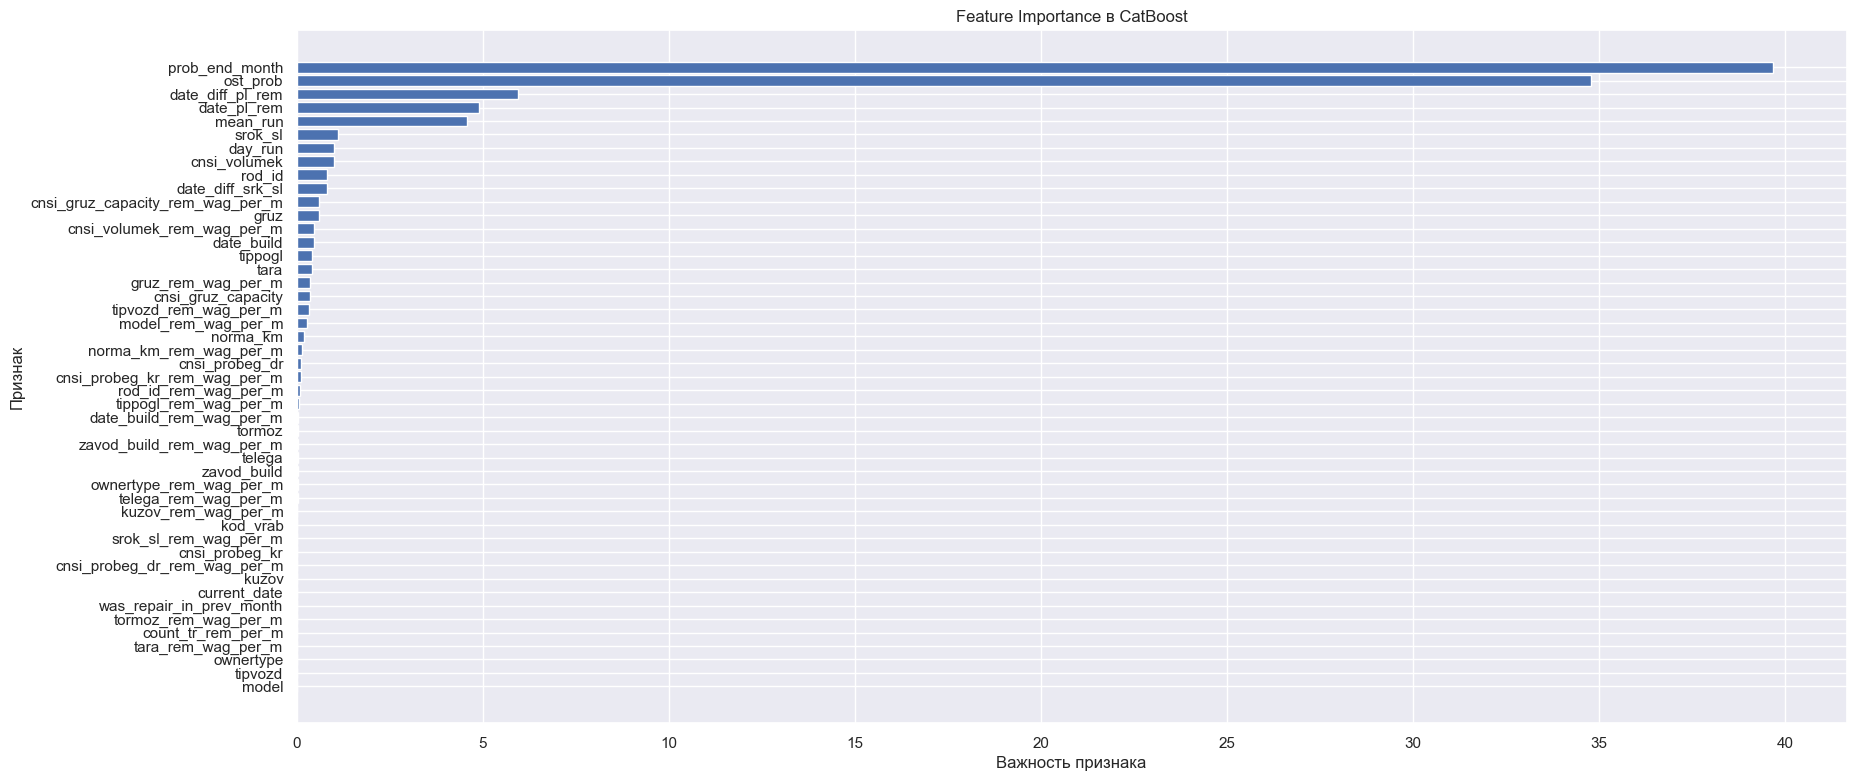

In [783]:
# Строим график важности признаков
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Feature Importance в CatBoost')
plt.show()

## Только важные признаки

In [792]:
X_train_filt_cool = X_train_filt[cool_feat]

In [793]:
X_train_filt_cool

,prob_end_month,ost_prob,date_diff_pl_rem,date_pl_rem,mean_run,srok_sl,day_run,cnsi_volumek,rod_id,date_diff_srk_sl,...,tippogl,tara,gruz_rem_wag_per_m,cnsi_gruz_capacity,tipvozd_rem_wag_per_m,model_rem_wag_per_m,norma_km,norma_km_rem_wag_per_m,cnsi_probeg_dr,cnsi_probeg_kr_rem_wag_per_m
wagnum,,,,,,,,,,,,,,,,,,,,,
0,58914.344262,63190,-209 days,2023-05-06,157.565574,2025-12-03,142.521858,122.0,0,733 days,...,11,244,1.847788,680,1.966179,1.861723,160000,1.978170,110,1.976443
2,55634.901639,59169,262 days,2024-08-19,83.409836,2026-11-15,117.803279,122.0,0,1080 days,...,15,252,1.847788,680,1.966179,0.000000,110000,1.998404,110,1.976443
3,62971.754098,67032,122 days,2024-04-01,136.02459,2025-10-03,135.341530,120.0,0,672 days,...,1,220,1.847788,680,2.046839,2.000000,110000,1.998404,110,1.976443
4,104816.213115,108149,363 days,2024-11-28,63.278689,2028-08-01,111.092896,120.0,0,1705 days,...,1,235,1.847788,680,2.003456,0.000000,160000,1.978170,110,1.976443
5,101901.491803,106036,271 days,2024-08-28,143.45082,2028-09-25,137.816940,122.0,0,1760 days,...,1,240,2.103571,688,2.046839,2.103571,160000,1.978170,110,1.976443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33970,140423.983607,153898,-56 days,2023-10-06,1077.401639,2033-03-23,449.133880,88.0,1,3400 days,...,11,245,1.973677,690,1.961013,1.931172,160000,1.978170,110,1.976443
33971,23491.737705,28076,135 days,2024-04-14,188.42623,2032-08-30,152.808743,77.0,1,3195 days,...,11,235,2.050967,700,1.966179,2.000000,160000,1.978170,110,1.976443
33973,136868.918033,151194,14 days,2023-12-15,1162.508197,2032-10-09,477.502732,77.0,1,3235 days,...,12,235,2.050967,700,1.966179,2.000000,160000,1.978170,110,1.976443


In [799]:
clf_new_filt_cool = CatBoostClassifier(iterations=2000, depth=8, learning_rate=0.05, loss_function='Logloss', auto_class_weights='SqrtBalanced', verbose=False)

In [ ]:
clf_new_filt_cool.fit(X_train_filt_cool, y_train_filt)

In [ ]:
cross_val_score(clf_new_filt_cool, X_train_filt_cool, y_train_filt, scoring = 'f1', cv=5).mean()

# Модель с фильтром. Дни

## Создаем данные

In [551]:
df_pred_binary_filt =\
df_pred_binary.query('pred == 1')

In [552]:
df_pred_binary_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, 91 to 33968
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pred    1785 non-null   int32
dtypes: int32(1)
memory usage: 22.7 KB


In [553]:
df_pred_binary_filt.head()

,pred
wagnum,
91,1
138,1
163,1
180,1
200,1


In [554]:
X_train_filt_day = X_train_filt[X_train_filt.index.isin(df_pred_binary_filt.index)]

In [555]:
X_train_filt_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, 91 to 33968
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             1785 non-null   string         
 1   rod_id                            1785 non-null   Int64          
 2   gruz                              1785 non-null   Int64          
 3   cnsi_gruz_capacity                1785 non-null   Int64          
 4   cnsi_volumek                      1785 non-null   Float64        
 5   tara                              1785 non-null   Int64          
 6   date_build                        1785 non-null   datetime64[ns] 
 7   srok_sl                           1785 non-null   datetime64[ns] 
 8   zavod_build                       1785 non-null   Int64          
 9   cnsi_probeg_dr                    1785 non-null   Int64          
 10  cnsi_probeg_kr                    1785 

In [556]:
target_day = target[target.month == '2022-12-01'][['wagnum', 'target_day']]

In [557]:
target_day.set_index('wagnum', inplace=True)

In [558]:
target_day.head()

,target_day
wagnum,
33361,0
33364,1
33366,1
33358,0
33349,0


In [559]:
y_train_filt_day = target_day[target_day.index.isin(df_pred_binary_filt.index)]

In [560]:
y_train_filt_day

,target_day
wagnum,
33364,1
33366,1
29890,0
29906,0
29933,1
...,...
29880,0
29909,1
33468,0


In [576]:
y_train_filt_day.value_counts()

target_day
0             1280
1              505
dtype: int64

## Обучаем

In [775]:
clf_new_filt_day = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.01, auto_class_weights='Balanced', loss_function='Logloss', cat_features=cols_cat_n_list, verbose=False)

In [776]:
clf_new_filt_day.fit(X_train_filt_day, y_train_filt_day)

0:	learn: 0.6928167	total: 54.2ms	remaining: 5.37s
1:	learn: 0.6926506	total: 126ms	remaining: 6.16s
2:	learn: 0.6924572	total: 193ms	remaining: 6.24s
3:	learn: 0.6922801	total: 260ms	remaining: 6.24s
4:	learn: 0.6920769	total: 308ms	remaining: 5.86s
5:	learn: 0.6918617	total: 353ms	remaining: 5.53s
6:	learn: 0.6916230	total: 424ms	remaining: 5.63s
7:	learn: 0.6914726	total: 469ms	remaining: 5.39s
8:	learn: 0.6913489	total: 534ms	remaining: 5.4s
9:	learn: 0.6911701	total: 590ms	remaining: 5.31s
10:	learn: 0.6910529	total: 649ms	remaining: 5.25s
11:	learn: 0.6906054	total: 736ms	remaining: 5.4s
12:	learn: 0.6904467	total: 795ms	remaining: 5.32s
13:	learn: 0.6902470	total: 853ms	remaining: 5.24s
14:	learn: 0.6900123	total: 926ms	remaining: 5.25s
15:	learn: 0.6897457	total: 980ms	remaining: 5.15s
16:	learn: 0.6895966	total: 1.07s	remaining: 5.22s
17:	learn: 0.6894068	total: 1.16s	remaining: 5.28s
18:	learn: 0.6891607	total: 1.2s	remaining: 5.13s
19:	learn: 0.6889583	total: 1.25s	remaining

In [777]:
cross_val_score(clf_new_filt_day, X_train_filt_day, y_train_filt_day, scoring = 'f1', cv=5, verbose=False).mean()

0:	learn: 0.6928451	total: 60.7ms	remaining: 6s
1:	learn: 0.6926154	total: 159ms	remaining: 7.79s
2:	learn: 0.6924712	total: 224ms	remaining: 7.23s
3:	learn: 0.6922137	total: 297ms	remaining: 7.12s
4:	learn: 0.6919985	total: 359ms	remaining: 6.82s
5:	learn: 0.6918237	total: 422ms	remaining: 6.61s
6:	learn: 0.6915743	total: 482ms	remaining: 6.41s
7:	learn: 0.6910877	total: 617ms	remaining: 7.1s
8:	learn: 0.6909523	total: 698ms	remaining: 7.05s
9:	learn: 0.6908232	total: 767ms	remaining: 6.91s
10:	learn: 0.6907353	total: 829ms	remaining: 6.7s
11:	learn: 0.6903723	total: 881ms	remaining: 6.46s
12:	learn: 0.6900038	total: 966ms	remaining: 6.46s
13:	learn: 0.6895559	total: 1.04s	remaining: 6.37s
14:	learn: 0.6894439	total: 1.06s	remaining: 6s
15:	learn: 0.6892175	total: 1.16s	remaining: 6.1s
16:	learn: 0.6889970	total: 1.24s	remaining: 6.03s
17:	learn: 0.6889001	total: 1.28s	remaining: 5.84s
18:	learn: 0.6886066	total: 1.33s	remaining: 5.67s
19:	learn: 0.6883266	total: 1.39s	remaining: 5.55

0.24866983194396824

``f1 = 0.248``

In [778]:
pred_filt_day =\
clf_new_filt_day.predict(X_train_filt_day)

In [779]:
sum(pred_filt_day)

786

## TH

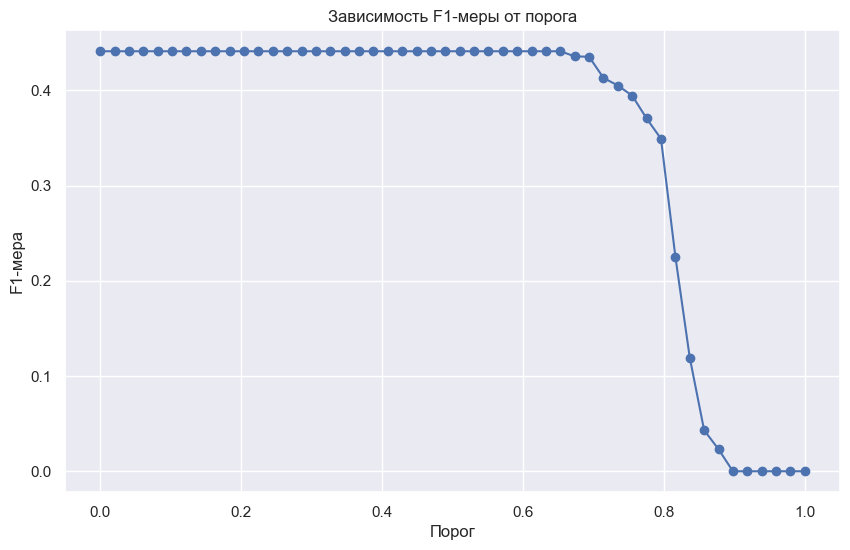

Лучший порог: 0.0


In [586]:
y_pred1 = clf_new_filt.predict_proba(X_train_filt_day)[:, 1]
y_true = y_train_filt_day

thresholds = np.linspace(0, 1, 50)  # Здесь используется 100 равномерно распределенных порогов от 0 до 1

f1_scores = []
threshold_values = []

# Перебор порогов
for threshold in thresholds:
    y_pred_binary_plot = (y_pred1 > threshold).astype(int)
    f1 = f1_score(y_true, y_pred_binary_plot)
    f1_scores.append(f1)
    threshold_values.append(threshold)

# Постройте график
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, f1_scores, marker='o', linestyle='-')
plt.xlabel('Порог')
plt.ylabel('F1-мера')
plt.title('Зависимость F1-меры от порога')
plt.grid(True)
plt.show()

# Подсчет лучшего порога

best_threshold_index = np.argmax(f1_scores)
best_threshold = threshold_values[best_threshold_index]

print(f"Лучший порог: {best_threshold}")

In [744]:
best_threshold_day = 0.75

In [745]:
y_pred_tr1 = clf_new_filt.predict_proba(X_train_filt_day)[:, 1]  # Получение вероятностей положительного класса
y_pred_binary_tr1 = (y_pred_tr1 > best_threshold_day).astype(int)  # Бинарные предсказания
f1 = f1_score(y_pred_binary_tr1, y_train_filt_day)
f1

0.3957685127566895

In [633]:
y_pred_tr1

array([0.78935109, 0.76791753, 0.81152455, ..., 0.7288563 , 0.81375925,
       0.72280725])

In [634]:
len(y_pred_binary_tr1)

1785

In [635]:
df_pred_binary_day =\
pd.DataFrame(y_pred_binary_tr1, columns=['pred'], index=y_train_filt_day.index)

In [636]:
df_pred_binary_day.sum()

pred    1102
dtype: int64

In [637]:
df_pred_binary_day.count()

pred    1785
dtype: int64

In [780]:
df_pred_binary_day['pred'].value_counts()

1    1102
0     683
Name: pred, dtype: int64

# Оценка полной f1

## True

In [638]:
target_check_true = target[target.month == '2022-12-01'][['wagnum', 'target_month', 'target_day']]

In [639]:
target_check_true.set_index('wagnum', inplace=True)

In [640]:
target_check_true.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 33361 to 33350
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   target_month  33977 non-null  Int64
 1   target_day    33977 non-null  Int64
dtypes: Int64(2)
memory usage: 895.9 KB


In [641]:
target_check_true.head()

,target_month,target_day
wagnum,,
33361,0,0
33364,1,1
33366,1,1
33358,0,0
33349,0,0


In [485]:
# target_check_true.to_csv('test_1_true.csv')

## Pred

In [642]:
target_check_pred = target[target.month == '2022-12-01'][['wagnum']]

In [643]:
target_check_pred.set_index('wagnum', inplace=True)

In [644]:
target_check_pred =\
target_check_pred.join(df_pred_binary, how='left')

In [645]:
target_check_pred.rename(columns={'pred': 'target_month'}, inplace=True)

In [646]:
target_check_pred.head()

,target_month
wagnum,
33361,NaN
33364,1.0
33366,1.0
33358,0.0
33349,0.0


In [647]:
target_check_pred =\
target_check_pred.join(df_pred_binary_day, how='left')

In [648]:
target_check_pred.rename(columns={'pred': 'target_day'}, inplace=True)

In [649]:
target_check_pred.fillna(0, inplace=True)

In [650]:
target_check_pred[['target_month', 'target_day']] = target_check_pred[['target_month', 'target_day']].astype(int)

In [651]:
target_check_pred.head()

,target_month,target_day
wagnum,,
33361,0,0
33364,1,1
33366,1,1
33358,0,0
33349,0,0


In [652]:
target_check_pred['target_month'].sum(), target_check_pred['target_day'].sum()

(1785, 1102)

In [496]:
# target_check_pred.to_csv('test_1_pred.csv')

In [653]:
def calc_f1_score(true_labels, pred_labels) -> float:
    # Таргет для месячного прогноза
    true_labels_month = true_labels['target_month'].values
    pred_labels_month = pred_labels['target_month'].values

    # Таргет для 10 дневного прогноза
    true_labels_day = true_labels['target_day'].values
    pred_labels_day = pred_labels['target_day'].values

    # Посчитаем метрику для месяца и 10 дней
    score_month = f1_score(true_labels_month, pred_labels_month)
    score_day = f1_score(true_labels_day, pred_labels_day)
    # Посчитаем метрику с весом для двух таргетов
    score = 0.5 * score_month + 0.5 * score_day
    return score

In [654]:
# оценим насколько хорошо удалось предсказать выбытие вагонов  по месяцу и по 10 дням
calc_f1_score(target_check_true, target_check_pred)

0.5425214558293248

# Тестим predict

## Функция для создания данных

In [715]:
def make_wp_test(wag_param, wag_prob, pr_rem, tr_rem, dislok, target, month_to_predict='2023-01-01', month_prev=12, info=False):
    '''
    Передаём: параметры вагона, пробег вагона, плановые ремонты, дислокацию, таргет
    дату отчёта на которую предиктим (по умолчанию 2023-01-01), 
    предыдущий месяц от даты отчёта (по умолчанию 12)
    , информация о датасетах
    
    Возвращает: сэмпл фичей для обработки, target
    '''
    
    # Достаём ТАРГЕТ для нужной даты month_to_predict
    target.month = pd.to_datetime(target.month)
    
    target = target[target.month == month_to_predict]
    print('target', target['month'].unique())
    target = target[['wagnum','month']]
    
    
    print('\nДостаём данные')
    # Достаём ПРОБЕГ для нужной даты month_to_predict
    wag_prob = wag_prob[(wag_prob.repdate == wag_prob.repdate.max()) | (wag_prob.repdate == wag_prob.repdate.min())]
    
    print('\nwag_prob', wag_prob['repdate'].unique())
    
    # Оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
    wag_prob_ = wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
    wag_prob_.columns = [head+'_' + name
                         if head!='wagnum'
                         else head
                         for head, name in wag_prob_.columns ]

    wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
    wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
    wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['wagnum','ost_prob']]
    wag_prob = wag_prob.merge(wag_prob_[['wagnum','mean_run']])
    
    print('\nwag_param')
    # Достаём ПАРАМЕТРЫ вагона для нужной даты month_to_predict. У вагонов могут меняться параметры, поэтмоу номер дублируется
    wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
    # wag_param = wag_param[['wagnum','srok_sl','cnsi_probeg_dr','cnsi_probeg_kr']]
    wag_param = all_rems_for_wagon(tr_rem, wag_param, month_to_predict, True)
    wag_param = wag_param.drop(columns=['date_iskl'])
    # print(wag_param)
    
    
    # Достаём данные по ПЛАНОВЫМ ремонтам за прошедший месяц
    pr_rem = pr_rem[pr_rem['month'] == month_prev].copy()
    
    print('\npr_rem', pr_rem['month'].unique()[0])
    
    # добавим признак, что вагон был в ПР в предыдущем месяце. Скорее всего, если вагон был в ПР недавно, то повторно он не поедет
    pr_rem['was_repair_in_prev_month'] = 1
    # print(pr_rem)
    # pr_rem = pr_rem[['wagnum','was_repair_in_prev_month']]
    pr_rem = pr_rem.drop_duplicates(subset='wagnum') #некоторые вагоны все же ремонтируются больше 1 раза, поэтому нужен сбросить дубли
    print(pr_rem[['rem_month']])
    pr_rem = pr_rem[['wagnum', 'was_repair_in_prev_month']]
    
    # Достаём данные по ТЕКУЩИМ ремонтам за прошедший месяц
    tr_rem = tr_rem[tr_rem['rem_month'].dt.month == month_prev]
    
    print('tr_rem', tr_rem['rem_month'].dt.month.unique()[0])
    
    tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()
    
    
    # Достаём данные по ДИСЛОКАЦИИ для нужной даты month_to_predict
    dislok = dislok[dislok['plan_date'] <= month_to_predict] \
    .drop_duplicates(subset = 'wagnum', keep='last')
    print('\ndislok', dislok['plan_date'].unique())
    
    # Показать инфо
    if info:
        print('\n', wag_prob.info())
        print('\n', wag_param.info())
        print('\n', pr_rem.info())
        print('\n', tr_rem.info())
        print('\n', dislok.info())
    
    print('\nДелаем фичи')
    # Создаём фичи
    wp = target[['wagnum']].merge(wag_param, on ='wagnum', how = 'left')\
    .merge(wag_prob, how = 'left')\
    .merge(pr_rem, how = 'left')\
    .merge(tr_rem, how = 'left')\
    .merge(dislok[['wagnum','date_pl_rem']], how = 'left')
    

    print('\nЗаполняме пропуски')
    numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # Заменим отсутствующие значения на нули
    wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    return wp, target

In [693]:
def make_features_wp_test(wp, month=True):
    '''
     Передаём: сэмпл фичей, target
     таргет за месяц (по умолчанию) или месяц + 10 дней
     
     Возрашает: фичи
    '''
    
    print('Считаем среднедневный пробег')
    # Считаем среднедневный пробег
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']] =\
    # wp[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run', 'was_repair_in_prev_month', 'kod_vrab']].fillna(0)
    wp['day_run'] = wp.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
    wp['day_run']= wp.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

    wp['current_date'] = month_to_predict
    # Дней до окончания срока службы на month_to_predict
    wp['date_diff_srk_sl'] = wp['srok_sl']- wp['current_date']
    # Дней до планового ремонта на month_to_predict
    wp['date_diff_pl_rem'] = wp['date_pl_rem']- wp['current_date']
    # Остаточный пробег на конец месяца
    wp['prob_end_month'] = wp['ost_prob'] - wp['day_run']* 30
    
    # print('Заполняме пропуски')
    # numeric_columns = wp.select_dtypes(include=['int', 'float'])
    # # Заменим отсутствующие значения на нули
    # wp[numeric_columns.columns] = numeric_columns.fillna(0)
    
    print('Сортируем номега вагонов')
    # Фичи
    X = wp.set_index('wagnum').sort_index()
        
    return X

## Файлы

In [663]:
path_train_v2 = './train/test'

In [666]:
# данные по дислокации
dislok_clear_v2 = pd.read_parquet(path_train_v2 + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_clear_v2 = pd.read_parquet(path_train_v2 + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param_clear_v2 = pd.read_parquet(path_train_v2 + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target_clear_v2 = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem_clear_v2 = pd.read_parquet(path_train_v2 + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_clear_v2 = pd.read_parquet(path_train_v2 + '/pr_rems.parquet').convert_dtypes()

In [700]:
dislok_clear_all = pd.concat([dislok_clear, dislok_clear_v2])
wag_prob_clear_all = pd.concat([wag_prob_clear, wag_prob_clear_v2])
tr_rem_clear_all = pd.concat([tr_rem_clear, tr_rem_clear_v2])
pr_rem_clear_all = pd.concat([pr_rem_clear, pr_rem_clear_v2])

In [687]:
target_clear_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wagnum  33707 non-null  Int64         
 1   month   33707 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1)
memory usage: 559.7 KB


### Значения дат срезов

In [714]:
wag_prob_clear_v2['repdate'].unique()

array(['2023-02-01T00:00:00.000000000', '2023-02-02T00:00:00.000000000',
       '2023-02-03T00:00:00.000000000', '2023-02-04T00:00:00.000000000',
       '2023-02-05T00:00:00.000000000', '2023-02-06T00:00:00.000000000',
       '2023-02-07T00:00:00.000000000', '2023-02-08T00:00:00.000000000',
       '2023-02-09T00:00:00.000000000', '2023-02-10T00:00:00.000000000',
       '2023-02-11T00:00:00.000000000', '2023-02-12T00:00:00.000000000',
       '2023-02-13T00:00:00.000000000', '2023-02-14T00:00:00.000000000',
       '2023-02-15T00:00:00.000000000', '2023-02-16T00:00:00.000000000',
       '2023-02-17T00:00:00.000000000', '2023-02-18T00:00:00.000000000',
       '2023-02-19T00:00:00.000000000', '2023-02-20T00:00:00.000000000',
       '2023-02-21T00:00:00.000000000', '2023-02-22T00:00:00.000000000',
       '2023-02-23T00:00:00.000000000', '2023-02-24T00:00:00.000000000',
       '2023-02-25T00:00:00.000000000', '2023-02-26T00:00:00.000000000',
       '2023-02-27T00:00:00.000000000', '2023-02-28

In [713]:
wag_prob_clear_all['repdate'].unique()

array(['2022-08-01T00:00:00.000000000', '2022-08-02T00:00:00.000000000',
       '2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-14T00:00:00.000000000',
       '2022-08-15T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-08-17T00:00:00.000000000', '2022-08-18T00:00:00.000000000',
       '2022-08-19T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-21T00:00:00.000000000', '2022-08-22T00:00:00.000000000',
       '2022-08-23T00:00:00.000000000', '2022-08-24T00:00:00.000000000',
       '2022-08-25T00:00:00.000000000', '2022-08-26T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-08-28

## Тестовый датасет февраль

In [716]:
# %%time
wp_test_real, target_test_real = make_wp_test(wag_param_clear_v2, wag_prob_clear_all, pr_rem_clear_all, tr_rem_clear_all, dislok_clear_all, target_clear_v2, '2023-03-01', 2)

target ['2023-03-01T00:00:00.000000000']

Достаём данные

wag_prob ['2022-08-01T00:00:00.000000000' '2023-02-28T00:00:00.000000000']

wag_param

Месяца count_rems_per_month_one_wag [ 8  9 10 11 12  1  2] 

Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]
Месяца [ 8  9 10 11 12  1  2]

pr_rem 2
      rem_month
0    2023-02-03
2    2023-02-10
3    2023-02-16
4    2023-02-16
5    2023-02-21
...         ...
1883 2023-02-28
1884 2023-02-28
1890 2023-02-24
1895 2023-02-02
1896 2023-02-21

[1589 rows x 1 columns]
tr_rem 2

dislok ['2022-12-

In [717]:
wp_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   wagnum                            33707 non-null  Int64         
 1   model                             33707 non-null  string        
 2   rod_id                            33707 non-null  Int64         
 3   gruz                              33707 non-null  Int64         
 4   cnsi_gruz_capacity                33707 non-null  Int64         
 5   cnsi_volumek                      33707 non-null  Float64       
 6   tara                              33707 non-null  Int64         
 7   date_build                        33707 non-null  datetime64[ns]
 8   srok_sl                           33707 non-null  datetime64[ns]
 9   zavod_build                       33707 non-null  Int64         
 10  cnsi_probeg_dr                    33707 non-nu

In [718]:
wp_test_real.head()

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,...,tormoz_rem_wag_per_m,tipvozd_rem_wag_per_m,tippogl_rem_wag_per_m,norma_km_rem_wag_per_m,ownertype_rem_wag_per_m,ost_prob,mean_run,was_repair_in_prev_month,kod_vrab,date_pl_rem
0,33361,12-1303-01,1,690,690,88.0,245,2011-02-08,2033-03-01,6,...,1.960699,1.936906,1.976244,1.972471,1.968486,140585,630.540284,0.0,0.0,2023-02-17
1,33364,12-1303-01,1,690,690,88.0,245,2010-04-21,2031-04-12,6,...,1.960699,1.936906,1.976244,1.972471,1.968486,144191,507.526066,0.0,0.0,2023-10-03
2,33366,12-1303-01,1,690,690,88.0,245,2010-06-23,2032-01-21,6,...,1.960699,1.936906,1.976244,1.972471,1.968486,150649,665.436019,0.0,0.0,2023-04-03
3,33358,12-1303-01,1,690,690,88.0,245,2012-09-27,2032-11-30,6,...,1.960699,1.936906,1.976244,1.972471,1.968486,14715,128.492891,0.0,0.0,2024-02-23
4,33349,12-1303-01,1,690,690,88.0,245,2011-11-20,2033-12-04,6,...,1.960699,1.988983,1.976244,1.972471,1.968486,139618,634.578199,0.0,0.0,2023-07-06


In [719]:
wp_test_real['mean_run'].value_counts()

0.0           1712
138.454976       6
145.227488       6
161.251185       6
156.49763        6
              ... 
566.312796       1
84.772512        1
173.080569       1
127.2891         1
<NA>             1
Name: mean_run, Length: 25957, dtype: Int64

In [720]:
wp_test_real['was_repair_in_prev_month'].value_counts()

0.0    32118
1.0     1589
Name: was_repair_in_prev_month, dtype: int64

In [707]:
wp_test_real['kod_vrab'].value_counts()

0.0    29785
2.0     2989
1.0      717
4.0      135
3.0       73
6.0        6
5.0        2
Name: kod_vrab, dtype: int64

In [752]:
target_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33707 entries, 0 to 33706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wagnum  33707 non-null  Int64         
 1   month   33707 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1)
memory usage: 822.9 KB


In [315]:
# target_train.value_counts()

In [721]:
X_test_real = make_features_wp_test(wp_test_real)

Считаем среднедневный пробег
Сортируем номега вагонов


In [722]:
X_test_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 0 to 33976
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             33707 non-null  string         
 1   rod_id                            33707 non-null  Int64          
 2   gruz                              33707 non-null  Int64          
 3   cnsi_gruz_capacity                33707 non-null  Int64          
 4   cnsi_volumek                      33707 non-null  Float64        
 5   tara                              33707 non-null  Int64          
 6   date_build                        33707 non-null  datetime64[ns] 
 7   srok_sl                           33707 non-null  datetime64[ns] 
 8   zavod_build                       33707 non-null  Int64          
 9   cnsi_probeg_dr                    33707 non-null  Int64          
 10  cnsi_probeg_kr                    33707

In [739]:
X_test_real.head()

,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,cnsi_probeg_dr,...,ost_prob,mean_run,was_repair_in_prev_month,kod_vrab,date_pl_rem,day_run,current_date,date_diff_srk_sl,date_diff_pl_rem,prob_end_month
wagnum,,,,,,,,,,,,,,,,,,,,,
0,11-276,0,680,680,122.0,244,1993-06-17,2025-12-03,1,110,...,42468,189.312796,0.0,0.0,2023-05-06,153.104265,2023-12-01,733 days,-209 days,37874.872038
1,11-066-04,0,680,680,120.0,220,1994-07-09,2026-03-07,1,110,...,83116,234.805687,0.0,0.0,2024-07-01,168.268562,2023-12-01,827 days,213 days,78067.943128
2,Р-9494-01,0,680,680,122.0,252,1994-10-30,2026-11-15,1,110,...,50236,90.563981,0.0,2.0,2024-08-19,120.187994,2023-12-01,1080 days,262 days,46630.36019
3,11-066-04,0,680,680,120.0,220,1993-10-04,2025-10-03,1,110,...,52596,147.066351,0.0,0.0,2024-04-01,139.022117,2023-12-01,672 days,122 days,48425.336493
4,11-217,0,680,680,120.0,235,1994-06-03,2028-08-01,23,110,...,87594,134.004739,0.0,0.0,2024-11-28,134.668246,2023-12-01,1705 days,363 days,83553.952607


In [723]:
X_test_real['day_run'].value_counts()

135.000000    1191
320.000000     460
160.000000      62
154.620853       6
145.707741       6
              ... 
132.323855       1
153.219589       1
146.789889       1
275.227488       1
298.532385       1
Name: day_run, Length: 26277, dtype: int64

## Предикт месяцев

In [724]:
y_pred_test_real = clf_new_filt.predict(X_test_real)

In [726]:
y_pred_test_real.sum()

1925

In [730]:
y_pred_test_pb = clf_new_filt.predict_proba(X_test_real)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_pb_binary = (y_pred_test_pb > best_threshold_m).astype(int)  # Бинарные предсказания

In [732]:
df_pred_test_binary =\
pd.DataFrame(y_pred_test_pb_binary, columns=['target_month'], index=X_test_real.index)

In [735]:
df_pred_test_binary.head()

,target_month
wagnum,
0,0
1,0
2,0
3,0
4,0


In [736]:
df_pred_test_binary['target_month'].value_counts()

0    32281
1     1426
Name: target_month, dtype: int64

## Предикт дней

In [740]:
X_test_real_day = X_test_real[X_test_real.index.isin(df_pred_test_binary[df_pred_test_binary['target_month'] == 1].index)]

In [741]:
X_test_real_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1426 entries, 4352 to 33971
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   model                             1426 non-null   string         
 1   rod_id                            1426 non-null   Int64          
 2   gruz                              1426 non-null   Int64          
 3   cnsi_gruz_capacity                1426 non-null   Int64          
 4   cnsi_volumek                      1426 non-null   Float64        
 5   tara                              1426 non-null   Int64          
 6   date_build                        1426 non-null   datetime64[ns] 
 7   srok_sl                           1426 non-null   datetime64[ns] 
 8   zavod_build                       1426 non-null   Int64          
 9   cnsi_probeg_dr                    1426 non-null   Int64          
 10  cnsi_probeg_kr                    142

In [742]:
y_pred_test_real_day = clf_new_filt_day.predict(X_test_real_day)

In [743]:
y_pred_test_real_day.sum()

707

In [746]:
y_pred_test_real_day_pb = clf_new_filt.predict_proba(X_test_real_day)[:, 1]  # Получение вероятностей положительного класса
y_pred_test_real_day_binary = (y_pred_test_real_day_pb > best_threshold_day).astype(int)  # Бинарные предсказания

In [748]:
df_pred_test_day_binary =\
pd.DataFrame(y_pred_test_real_day_binary, columns=['target_day'], index=X_test_real_day.index)

In [749]:
df_pred_test_day_binary.head()

,target_day
wagnum,
4352,1
5421,0
5448,1
5563,0
5588,0


In [751]:
df_pred_test_day_binary['target_day'].value_counts()

1    929
0    497
Name: target_day, dtype: int64

## Собираем файл

In [761]:
def collect_file_test(target, df_month, df_day):
    target_check_pred =\
    target.set_index('wagnum')
    
    target_check_pred =\
    target_check_pred.join(df_month, how='left')
    
    target_check_pred =\
    target_check_pred.join(df_day, how='left')
    
    target_check_pred.fillna(0, inplace=True)
    target_check_pred[['target_month', 'target_day']] = target_check_pred[['target_month', 'target_day']].astype(int)
    
    return target_check_pred

In [762]:
df_test_reall_v1 = collect_file_test(target_test_real, df_pred_test_binary, df_pred_test_day_binary)

In [763]:
df_test_reall_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33707 entries, 33361 to 8061
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   month         33707 non-null  datetime64[ns]
 1   target_month  33707 non-null  int32         
 2   target_day    33707 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.8 MB


In [764]:
df_test_reall_v1['target_month'].sum(), df_test_reall_v1['target_day'].sum()

(1426, 929)

In [765]:
df_test_reall_v1.to_csv('dodics_pred_v1.csv')

# Feature engineering v2